<a href="https://colab.research.google.com/github/catalinakarinip/mercadolabroal/blob/main/mercadolaboral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script 1: Limpieza bases INE

Para actualizar las bases limpias se debe
1. Subir las bbdd originales del INE
2. Ver si la base de diccionario "variables_por_base" mantiene las columnas, y por tanto las abreviaturas corresponden
3. Cambiar nombre del archivo al compatible con la base de diccionario

El code se demora 1 min en crear todas las bases limpias!!


In [ ]:
# ================= 0. MONTAR DRIVE =====================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ================= 1. LIBRERÍAS Y RUTA ========================================
from pathlib import Path
import pandas as pd
import re

ROOT = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio")
ORIG_DIR = ROOT / "Datos_ENE_originales"
CLEAN_DIR = ROOT / "Datos_ENE_limpios"
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

MAP_FILE = ROOT / "resultados/variables_por_base.xlsx"
MAP_SHEET = 0

# ================= 2. DICCIONARIO DE ABREVIATURAS =====================
def load_abbreviations() -> dict:
    df_map = (
        pd.read_excel(MAP_FILE, sheet_name=MAP_SHEET, usecols="A:C")
        .rename(columns=str.lower)
        .dropna()
    )
    df_map["base"] = (
        df_map["base"].str.strip().str.replace(".xlsx", "", regex=False).str.lower()
    )
    df_map["var_original"] = df_map["var_original"].str.strip()
    df_map["abreviatura"] = df_map["abreviatura"].str.strip()
    return {(r.base, r.var_original): r.abreviatura for r in df_map.itertuples()}

# ================= 4. HOJAS A CONSERVAR ================================
ID_VARS = ["Año", "Trimestre"]
HOJAS_OBJETIVO = {
    "AS",
    "AP",
    "TA",
    "AN",
    "AT",
    "CO",
    "VA",
    "RM",
    "LI",
    "ML",
    "NB",
    "BI",
    "AR",
    "LR",
    "LL",
    "AI",
    "MA",
}

# ================= 5. CONVERSIÓN NÚMEROS LATINOS =======================

LATIN_NUMBER_RE = re.compile(r"^\d{1,3}(\.\d{3})*(,\d+)?$")

def texto_a_numero(valor: str):
    if pd.isna(valor):
        return None
    texto = str(valor)
    if LATIN_NUMBER_RE.match(texto):
        texto = texto.replace(".", "").replace(",", ".")
    else:
        texto = texto.replace(",", ".")
    try:
        return float(texto)
    except ValueError:
        return None

# ================= 6. LIMPIADOR DE HOJAS ===============================
def limpiar_hoja(df: pd.DataFrame, base_alias: str, abbr: dict) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.str.strip()
    columnas_a_borrar = []
    renombres = {}
    columnas = list(df.columns)

    for i, col in enumerate(columnas):
        if col in ID_VARS or "Unnamed" not in col:
            continue
        anterior = columnas[i - 1].strip() if i > 0 else ""
        if anterior in ID_VARS or not anterior:
            columnas_a_borrar.append(col)
            continue
        alias = abbr.get((base_alias, anterior))
        if alias:
            renombres[col] = f"{alias}_{base_alias}"
        else:
            columnas_a_borrar.append(col)

    df = df.drop(columns=columnas_a_borrar, errors="ignore").rename(columns=renombres)
    df = df[df[ID_VARS[0]].notna() | df[ID_VARS[1]].notna()].reset_index(drop=True)

    # Normalize quarter names so they match TRIM_OK in unify_panel.py
    quarter_map = {
        "1": "Ene - Mar",
        "2": "Abr - Jun",
        "3": "Jul - Sep",
        "4": "Oct - Dic",
        "ene-mar": "Ene - Mar",
        "abr-jun": "Abr - Jun",
        "jul-sep": "Jul - Sep",
        "oct-dic": "Oct - Dic",
        "ene - mar": "Ene - Mar",
        "abr - jun": "Abr - Jun",
        "jul - sep": "Jul - Sep",
        "oct - dic": "Oct - Dic",
    }
    df["Trimestre"] = (
        df["Trimestre"].astype(str).str.strip().str.lower().replace(quarter_map)
    )
    df["Año"] = pd.to_numeric(df["Año"], errors="coerce")

    for col in renombres.values():
        df[col] = df[col].apply(texto_a_numero)

    return df[[*ID_VARS, *renombres.values()]]

# ================= 7. PROCESAR ARCHIVOS =================================
def procesar_archivos():
    abbr = load_abbreviations()
    for src in ORIG_DIR.glob("*.xlsx"):
        base_alias = src.stem.split("_")[0].lower()
        dest = CLEAN_DIR / f"{base_alias}_limpia.xlsx"
        if dest.exists():
            print(f"↻  Reemplazando {dest.name}")
        else:
            print(f"→ Procesando {src.name} (base={base_alias})")
        xls = pd.ExcelFile(src)
        with pd.ExcelWriter(dest, engine="openpyxl") as xlw:
            hojas_guardadas = 0
            for hoja in xls.sheet_names:
                if hoja not in HOJAS_OBJETIVO:
                    continue
                try:
                    raw = xls.parse(hoja, header=5, dtype=str)
                    limpio = limpiar_hoja(raw, base_alias, abbr)
                    if not limpio.empty:
                        limpio.to_excel(xlw, sheet_name=hoja, index=False)
                        hojas_guardadas += 1
                except Exception as e:
                    print(f"⚠️ Error en hoja '{hoja}': {e}")
            if hojas_guardadas == 0:
                print(f"⚠️ Ninguna hoja válida guardada en {src.name}")
    print("\n✅ Limpieza completada. Archivos en:", CLEAN_DIR)

if __name__ == "__main__":
    procesar_archivos()



↻  Reemplazando rama_limpia.xlsx
↻  Reemplazando informalidadtasas_limpia.xlsx
↻  Reemplazando informalidadrama_limpia.xlsx
↻  Reemplazando informalidadgrupo_limpia.xlsx
↻  Reemplazando informalidadcategoria_limpia.xlsx
↻  Reemplazando indicadoresprincipales_limpia.xlsx
↻  Reemplazando grupo_limpia.xlsx
↻  Reemplazando complementarios_limpia.xlsx
↻  Reemplazando categoria_limpia.xlsx

✅ Limpieza completada. Archivos en: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/Datos_ENE_limpios


# Script 2.1: Panel de datos

In [ ]:
# ================= 0. MONTAR DRIVE =====================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ================= 1. LIBRERÍAS Y PATH ========================================
from pathlib import Path
import pandas as pd
ROOT = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio")
CLEAN_DIR = ROOT / "Datos_ENE_limpios"
PANEL_FILE = ROOT / "resultados" / "panel_ENE_unificado.xlsx"

TRIM_OK = {"Ene - Mar", "Abr - Jun", "Jul - Sep", "Oct - Dic"}
MAPA = {
    "AP": "Arica y Parinacota",
    "TA": "Tarapacá",
    "AN": "Antofagasta",
    "AT": "Atacama",
    "CO": "Coquimbo",
    "VA": "Valparaíso",
    "RM": "Región Metropolitana",
    "LI": "O’Higgins",
    "ML": "Maule",
    "NB": "Ñuble",
    "BI": "Biobío",
    "AR": "Araucanía",
    "LR": "Los Ríos",
    "LL": "Los Lagos",
    "AI": "Aysén",
    "MA": "Magallanes",
    "AS": "Nacional",
}
REGIONES = set(MAPA.keys())
ID_VARS = ["Año", "Trimestre", "region_code", "region_name"]
TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# ================= 2.MAPEO INICIAL ===========================

def cargar_base(path: Path) -> pd.DataFrame:
    xls = pd.ExcelFile(path)
    registros = []
    for hoja in xls.sheet_names:
        if hoja not in REGIONES:
            continue
        df = pd.read_excel(xls, sheet_name=hoja)
        df = df[df["Trimestre"].isin(TRIM_OK)].copy()
        df["region_code"] = hoja
        df["region_name"] = MAPA[hoja]
        registros.append(df)
    if registros:
        return pd.concat(registros, ignore_index=True)
    return pd.DataFrame(columns=ID_VARS)


# ================= 3. CONSTRUCCIÓN DEL PANEL ===========================
def construir_panel():
    panel = None
    for archivo in CLEAN_DIR.glob("*_limpia.xlsx"):
        df_base = cargar_base(archivo)
        if df_base.empty:
            continue
        if panel is None:
            panel = df_base
        else:
            panel = pd.merge(panel, df_base, on=ID_VARS, how="outer")
    if panel is None:
        print("No se encontraron archivos limpios")
        return
    panel["Trimestre_num"] = panel["Trimestre"].map(TRIM_MAP)
    panel = (
        panel.sort_values(
            ["Año", "Trimestre_num", "region_code", "region_name"]
        )
        .drop(columns="Trimestre_num")
        .reset_index(drop=True)
    )
    panel["Periodo"] = pd.PeriodIndex(
        year=panel["Año"],
        quarter=panel["Trimestre"].map(TRIM_MAP),
        freq="Q",
    )
    panel["Fecha"] = panel["Periodo"].dt.start_time
    #panel["Periodo_str"] = panel["Periodo"].astype(str)

    PANEL_FILE.parent.mkdir(parents=True, exist_ok=True)
    if PANEL_FILE.exists():
        print(f"↻  Reemplazando {PANEL_FILE.name}")
    panel.to_excel(PANEL_FILE, index=False, sheet_name="panel_data")
    print("✅ Panel construido y guardado en:", PANEL_FILE)

if __name__ == "__main__":
    construir_panel()

<ipython-input-41-1241934044>:72: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  panel["Periodo"] = pd.PeriodIndex(


↻  Reemplazando panel_ENE_unificado.xlsx
✅ Panel construido y guardado en: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx


# Script 2.2: Panel BioBio vs Nacional

In [ ]:
# ================= Panel Biobío vs Nacional =====================
import pandas as pd
from pathlib import Path

# === Paths y variables ===
ROOT = Path('/content/drive/MyDrive/Data/Mercado_Laboral/Biobio')
PANEL_FILE = ROOT / 'resultados' / 'panel_ENE_unificado.xlsx'

vars_sel = [
    'T_TDO_indicadoresprincipales',
    'T_TO_indicadoresprincipales',
    'T_TP_indicadoresprincipales',
    'T_TOI_A_informalidadtasas',
    'T_TOI_H_informalidadtasas',
    'T_TOI_M_informalidadtasas',
]

TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# === Cargar y filtrar ===
df = pd.read_excel(PANEL_FILE, sheet_name='panel_data')
df = df[df['region_name'].isin(['Biobío', 'Nacional'])].copy()

# Añadir orden temporal
df["Trimestre_num"] = df["Trimestre"].map(TRIM_MAP)
df = df.sort_values(["Año", "Trimestre_num", "region_name"])

# Seleccionar columnas en orden
cols_final = ['Año', 'Trimestre', 'region_name'] + vars_sel
df_panel = df[cols_final]

# Guardar como nueva hoja
with pd.ExcelWriter(PANEL_FILE, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_panel.to_excel(writer, sheet_name='biobio_vs_nacional', index=False)

print(f"✅ Hoja «biobio_vs_nacional» creada con {len(df_panel)} filas.")


✅ Hoja «biobio_vs_nacional» creada con 122 filas.


In [ ]:
# ================= Panel Biobío vs Nacional =====================
import pandas as pd
from pathlib import Path

# === Paths y variables ===
ROOT = Path('/content/drive/MyDrive/Data/Mercado_Laboral/Biobio')
PANEL_FILE = ROOT / 'resultados' / 'panel_ENE_unificado.xlsx'

vars_sel = [
    'T_TDO_indicadoresprincipales',
    'T_TO_indicadoresprincipales',
    'T_TP_indicadoresprincipales',
    'T_TOI_A_informalidadtasas',
    'T_TOI_H_informalidadtasas',
    'T_TOI_M_informalidadtasas',
]

TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# === Cargar y filtrar ===
df = pd.read_excel(PANEL_FILE, sheet_name='panel_data')
df = df[df['region_name'].isin(['Biobío', 'Nacional'])].copy()

# Añadir periodo y fecha
df["Trimestre_num"] = df["Trimestre"].map(TRIM_MAP)
df["Periodo"] = pd.PeriodIndex.from_fields(
    year=df["Año"],
    quarter=df["Trimestre_num"],
    freq="Q"
)
df["Fecha"] = df["Periodo"].dt.start_time

# Ordenar y seleccionar columnas finales
df = df.sort_values(["Periodo", "region_name"])
cols_final = ['Periodo', 'Fecha', 'Año', 'Trimestre', 'region_name'] + vars_sel
df_panel = df[cols_final]

# Guardar como nueva hoja
with pd.ExcelWriter(PANEL_FILE, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_panel.to_excel(writer, sheet_name='biobio_vs_nacional', index=False)

print(f"✅ Hoja «biobio_vs_nacional» creada con {len(df_panel)} filas.")


✅ Hoja «biobio_vs_nacional» creada con 122 filas.


# Script 3: BBDD anual 2024

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# 1️⃣  Parámetros
archivo_excel = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
hoja_origen   = "panel_data"
anio          = 2024
hoja_filtrada = f"data_{anio}"
hoja_prom     = f"promedios_{anio}"

TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# 2️⃣  Leer la hoja principal y filtrar solo el año objetivo
df_anio = (
    pd.read_excel(archivo_excel, sheet_name="panel_data")
      .query("Año == @anio")
)

df_anio = pd.read_excel(archivo_excel, sheet_name=hoja_origen).query("Año == @anio").copy()

if "Periodo" not in df_anio.columns:
    df_anio["Trimestre_num"] = df_anio["Trimestre"].map(TRIM_MAP)
    df_anio["Periodo"] = pd.PeriodIndex.from_fields(df_anio["Año"], df_anio["Trimestre_num"], freq="Q")
    df_anio["Fecha"] = df_anio["Periodo"].dt.start_time
    df_anio.drop(columns="Trimestre_num", inplace=True)


# 3️⃣  Calcular promedios regionales
indicadores = [
    "T_TDO_indicadoresprincipales",
    "T_TO_indicadoresprincipales",
    "T_TP_indicadoresprincipales",
    "T_TOI_A_informalidadtasas",
    "T_TOI_H_informalidadtasas",
    "T_TOI_M_informalidadtasas",
]

promedios = (
    df_anio.groupby("region_name")[indicadores]
           .mean()
           .reset_index()
           .round(3)
)

# 4️⃣  Escribir ambas hojas dentro del mismo archivo
with pd.ExcelWriter(
        archivo_excel,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    df_anio.to_excel(writer, sheet_name=hoja_filtrada, index=False)
    promedios.to_excel(writer, sheet_name=hoja_prom, index=False)

print(f"✅ Hoja «{hoja_filtrada}» ({len(df_anio)} filas) y «{hoja_prom}» ({len(promedios)} regiones) creadas/actualizadas.")

✅ Hoja «data_2024» (68 filas) y «promedios_2024» (17 regiones) creadas/actualizadas.


# Script 4: BBDD anual 2025

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# 1️⃣  Parámetros
archivo_excel = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
hoja_origen   = "panel_data"
anio          = 2025
hoja_filtrada = f"data_{anio}"
hoja_prom     = f"promedios_{anio}"

TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# 2️⃣  Leer la hoja principal y filtrar solo el año objetivo
df_anio = (
    pd.read_excel(archivo_excel, sheet_name="panel_data")
      .query("Año == @anio")
)
df_anio = pd.read_excel(archivo_excel, sheet_name=hoja_origen).query("Año == @anio").copy()

if "Periodo" not in df_anio.columns:
    df_anio["Trimestre_num"] = df_anio["Trimestre"].map(TRIM_MAP)
    df_anio["Periodo"] = pd.PeriodIndex.from_fields(df_anio["Año"], df_anio["Trimestre_num"], freq="Q")
    df_anio["Fecha"] = df_anio["Periodo"].dt.start_time
    df_anio.drop(columns="Trimestre_num", inplace=True)

# 3️⃣  Calcular promedios regionales
indicadores = [
    "T_TDO_indicadoresprincipales",
    "T_TO_indicadoresprincipales",
    "T_TP_indicadoresprincipales",
    "T_TOI_A_informalidadtasas",
    "T_TOI_H_informalidadtasas",
    "T_TOI_M_informalidadtasas",
]

promedios = (
    df_anio.groupby("region_name")[indicadores]
           .mean()
           .reset_index()
           .round(3)
)

# 4️⃣  Escribir ambas hojas dentro del mismo archivo
with pd.ExcelWriter(
        archivo_excel,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    df_anio.to_excel(writer, sheet_name=hoja_filtrada, index=False)
    promedios.to_excel(writer, sheet_name=hoja_prom, index=False)

print(f"✅ Hoja «{hoja_filtrada}» ({len(df_anio)} filas) y «{hoja_prom}» ({len(promedios)} regiones) creadas/actualizadas.")

✅ Hoja «data_2025» (17 filas) y «promedios_2025» (17 regiones) creadas/actualizadas.


# Funciones

In [ ]:
# ========== CALCULAR VARIACIONES INTERANUALES ==========

from pathlib import Path
import pandas as pd

TRIM_MAP = {
    "Ene - Mar": 1,
    "Abr - Jun": 2,
    "Jul - Sep": 3,
    "Oct - Dic": 4,
}

# === Función para cargar y crear columna Periodo si no existe ===
def load_panel_variaciones(path: Path, sheet: str) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name=sheet)
    if "Periodo" not in df.columns:
        df["Trimestre_num"] = df["Trimestre"].map(TRIM_MAP)
        df["Periodo"] = pd.PeriodIndex(
            year=df["Año"],
            quarter=df["Trimestre_num"],
            freq="Q"
        )
    return df

# === Calcular variaciones ===
def add_variations(df: pd.DataFrame, variables: list[str]) -> pd.DataFrame:
    df = df.sort_values(["region_name", "Periodo"]).copy()
    for var in variables:
        # Variación interanual: diferencia con el mismo trimestre del año anterior
        df[f"{var}_da"] = df.groupby("region_name")[var].diff(periods=4)
    return df


    return df

# === Ruta y columnas a calcular ===
PANEL_FILE = Path('/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx')
SHEET_IN = "biobio_vs_nacional"
SHEET_OUT = "biobio_vs_nacional_variaciones"

# Cargar panel
df = load_panel_variaciones(PANEL_FILE, SHEET_IN)

# Seleccionar solo las columnas numéricas de interés (excluyendo Año, Fecha, etc.)
cols_num = df.select_dtypes("number").columns.difference(["Año", "Trimestre_num"])
df_var = add_variations(df, cols_num)

# Guardar como nueva hoja
with pd.ExcelWriter(PANEL_FILE, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    df_var.to_excel(writer, sheet_name=SHEET_OUT, index=False)

print(f"✅ Hoja «{SHEET_OUT}» creada con variaciones.")


✅ Hoja «biobio_vs_nacional_variaciones» creada con variaciones.


# Tablas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tablas excel

In [ ]:
import pandas as pd
from openpyxl import load_workbook

# ─── 1. Cargar datos ──────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")

# ─── 2. Filtrar datos Biobío ──────────────────────────────────────────────────
df_bio = df[df["region_name"] == "Biobío"].copy()
orden_trimestres = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}
df_bio["orden"] = df_bio["Trimestre"].map(orden_trimestres)
df_bio = df_bio.sort_values(["Año", "orden"]).drop(columns="orden")

# ─── 3. Renombrar columnas ────────────────────────────────────────────────────
column_map = {
    "PET_indicadoresprincipales": "Población en edad de trabajar",
    "FT_TOT_indicadoresprincipales": "Fuerza de trabajo",
    "PO_TOT_indicadoresprincipales": "Personas ocupadas",
    "PDO_TOT_indicadoresprincipales": "Personas desocupadas",
    "PO_F_TOT_informalidadrama": "Personas ocupadas formales",
    "PO_I_TOT_informalidadrama": "Personas ocupadas informales",
    "FFT_TOT_indicadoresprincipales": "Fuera de la fuerza de trabajo"
}

df_bio = df_bio.rename(columns=column_map)
df_bio = df_bio.round(2)

# ─── 4. Promedio anual ────────────────────────────────────────────────────────
variables = list(column_map.values())
df_promedio_anual = df_bio[["Año"] + variables].groupby("Año").mean(numeric_only=True).reset_index()
df_promedio_anual = df_promedio_anual.round(2)

# ─── 5. Calcular crecimiento interanual ───────────────────────────────────────
df_crecimiento_anual = df_promedio_anual.copy()
for var in variables:
    df_crecimiento_anual[f"% Δ {var}"] = df_crecimiento_anual[var].pct_change().round(4) * 100

# ─── 6. Tabla trimestral con columnas seleccionadas ───────────────────────────
df_trimestral = df_bio[["Año", "Trimestre"] + variables].copy()


# ─── 6. Calcular crecimiento interanual por trimestre móvil ───────────────────
for var in variables:
    df_trimestral[f"% Δ {var}"] = (
        df_trimestral
        .groupby("Trimestre")[var]
        .pct_change(periods=1) * 100
    ).round(2)


# ─── 7. Crecimiento acumulado Ene–Mar 2018 vs 2025 ───────────────────────────
df_marzo = df_trimestral[df_trimestral["Trimestre"] == "Ene - Mar"]
df_2018 = df_marzo[df_marzo["Año"] == 2018].set_index("Año")
df_2025 = df_marzo[df_marzo["Año"] == 2025].set_index("Año")

if not df_2018.empty and not df_2025.empty:
    crecimiento = ((df_2025[variables].values[0] / df_2018[variables].values[0]) - 1) * 100
    df_crecimiento_total = pd.DataFrame({
        "Variable": variables,
        "Crecimiento acumulado (%) 2018–2025": crecimiento.round(2)
    })
else:
    df_crecimiento_total = pd.DataFrame(columns=["Variable", "Crecimiento acumulado (%) 2018–2025"])

# ─── 8. Exportar todas a un solo archivo Excel ────────────────────────────────
with pd.ExcelWriter(ruta, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    df_trimestral.to_excel(writer, sheet_name="biobio_trimestres", index=False)
    df_crecimiento_anual.to_excel(writer, sheet_name="biobio_promedio_anual", index=False)
    df_crecimiento_total.to_excel(writer, sheet_name="crecimiento_2018_2025", index=False)

print("✅ Exportación completada.")


<ipython-input-60-421002387>:47: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change(periods=1) * 100
<ipython-input-60-421002387>:47: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change(periods=1) * 100


✅ Exportación completada.


# Tablas imagenes


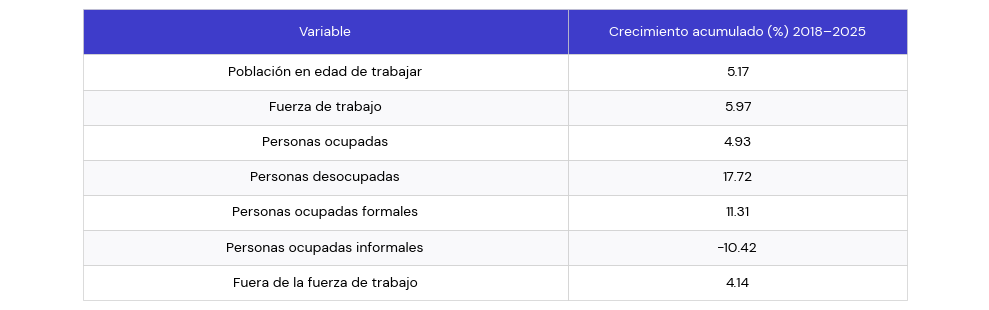

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ─── 1. Configurar fuente DM Sans ─────────────────────────────────────────────
font_path = "/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf"
if Path(font_path).exists():
    fm.fontManager.addfont(font_path)
    dm_font = fm.FontProperties(fname=font_path)
else:
    dm_font = fm.FontProperties()

# ─── 2. Cargar tabla ──────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="crecimiento_2018_2025")

# ─── 3. Formatear porcentaje con símbolo y coma ───────────────────────────────
df["Crecimiento acumulado (%) 2018–2025"] = df[
    "Crecimiento acumulado (%) 2018–2025"
].map(lambda x: f"{x:,.2f}")

# ─── 4. Crear tabla como imagen con estilo ────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 3.2))  # Aumenta altura del canvas
ax.axis("off")

column_labels = df.columns.tolist()
cell_data = df.values.tolist()

tabla = ax.table(
    cellText=[column_labels] + cell_data,
    cellLoc='center',
    loc='center'
)

tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1.1, 2.1)  # También puedes ajustar aquí

# Estilo de celdas
for (row, col), cell in tabla.get_celld().items():
    if row == 0:
        cell.set_facecolor("#3E3CCA")
        cell.set_text_props(color='white', weight='bold', fontproperties=dm_font)
        cell.set_height(0.18)  # Encabezado más alto
    else:
        cell.set_facecolor("#f9f9fb" if row % 2 == 0 else "white")
        cell.set_text_props(fontproperties=dm_font)
        cell.set_height(0.14)  # Aumenta la altura de filas
    cell.set_edgecolor("#CCCCCC")
    cell.set_linewidth(0.5)
    cell.set_width(0.5 if col == 0 else 0.35)

plt.tight_layout()
plt.savefig("/content/tabla_crecimiento_acumulado.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()


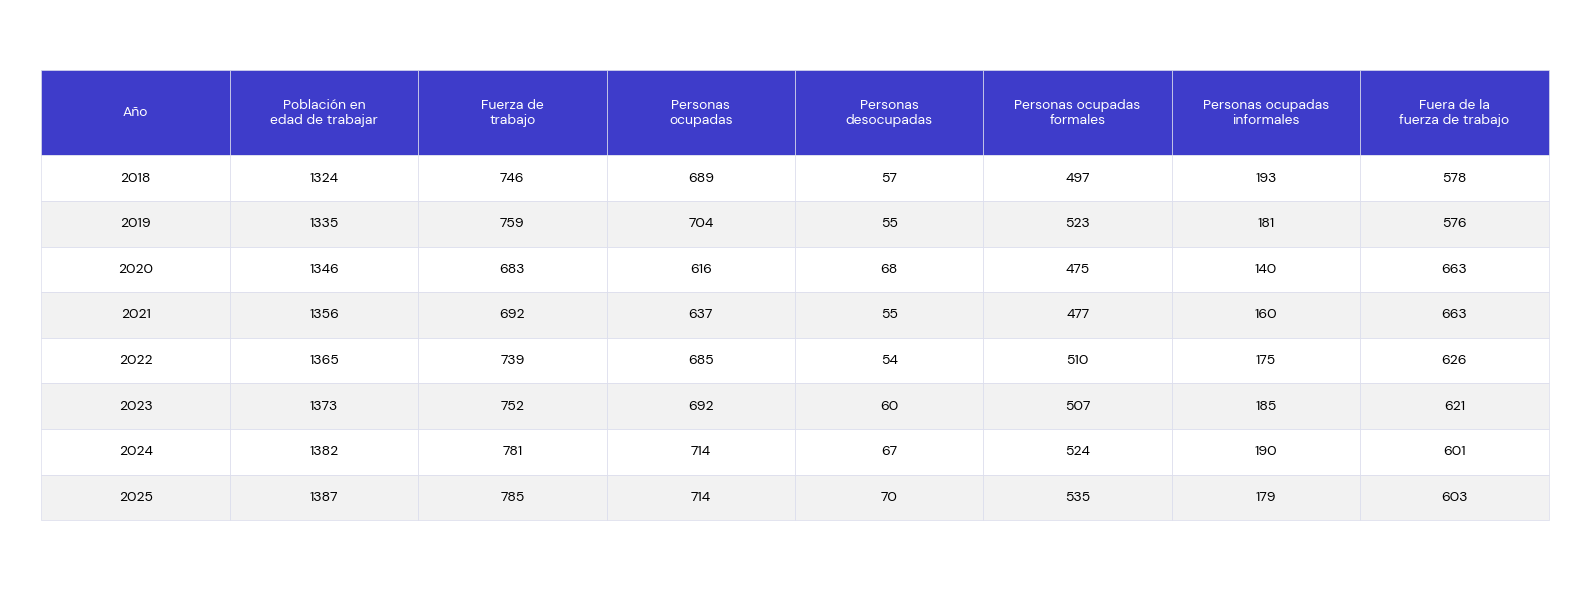

<ipython-input-79-2415737670>:147: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


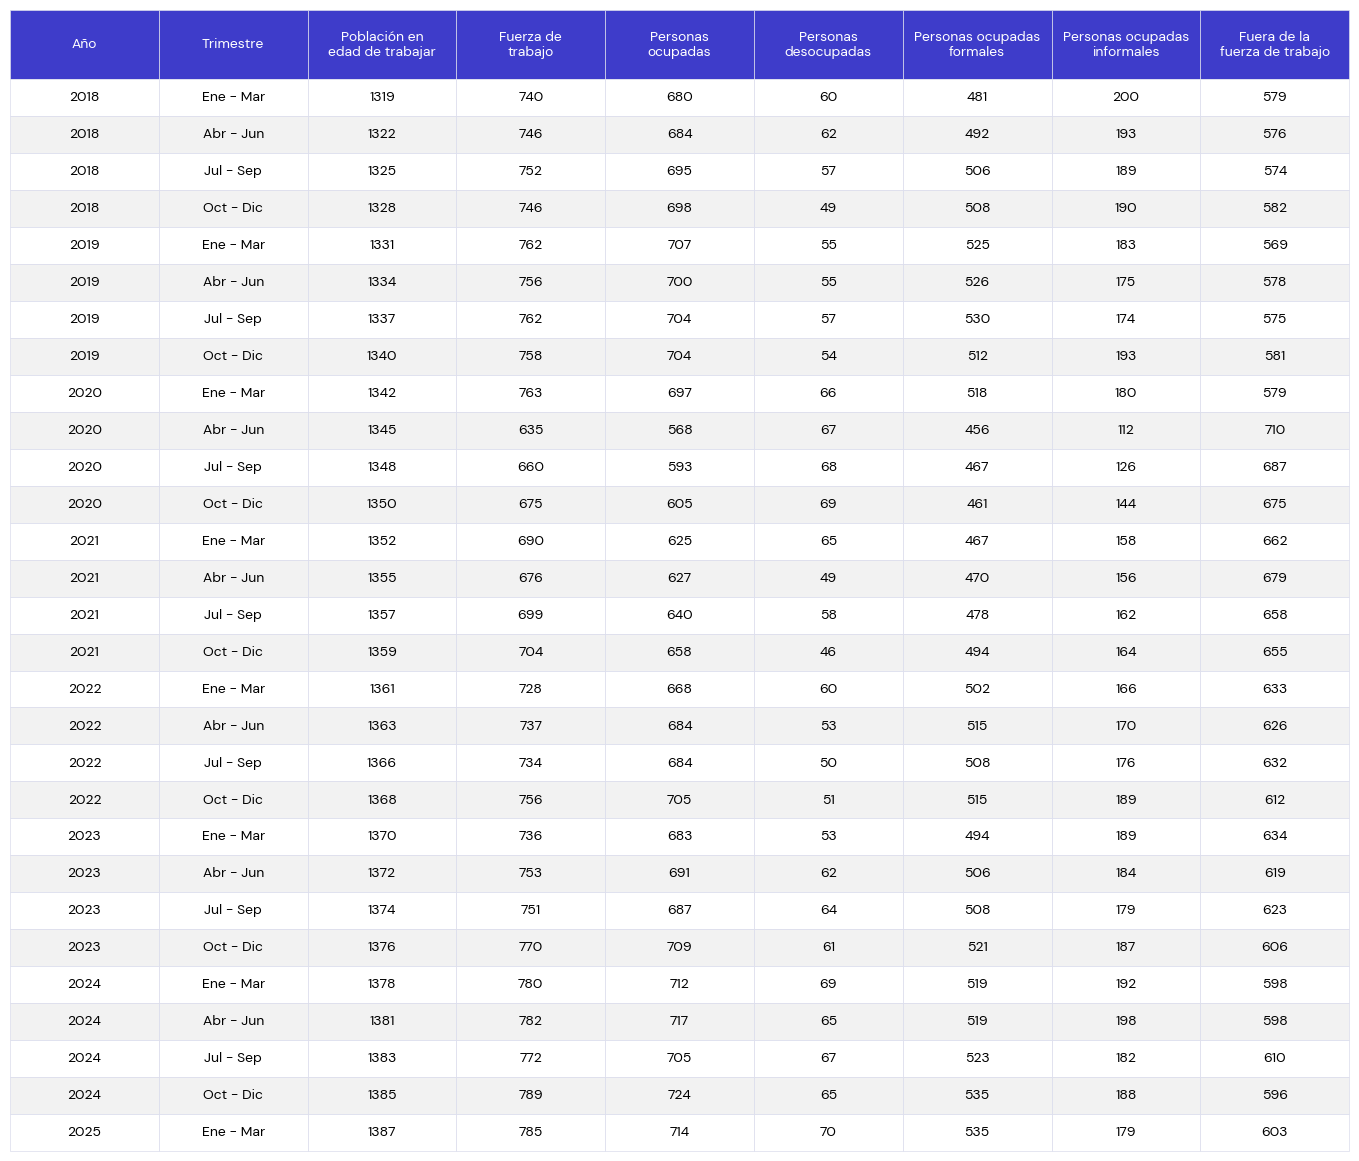

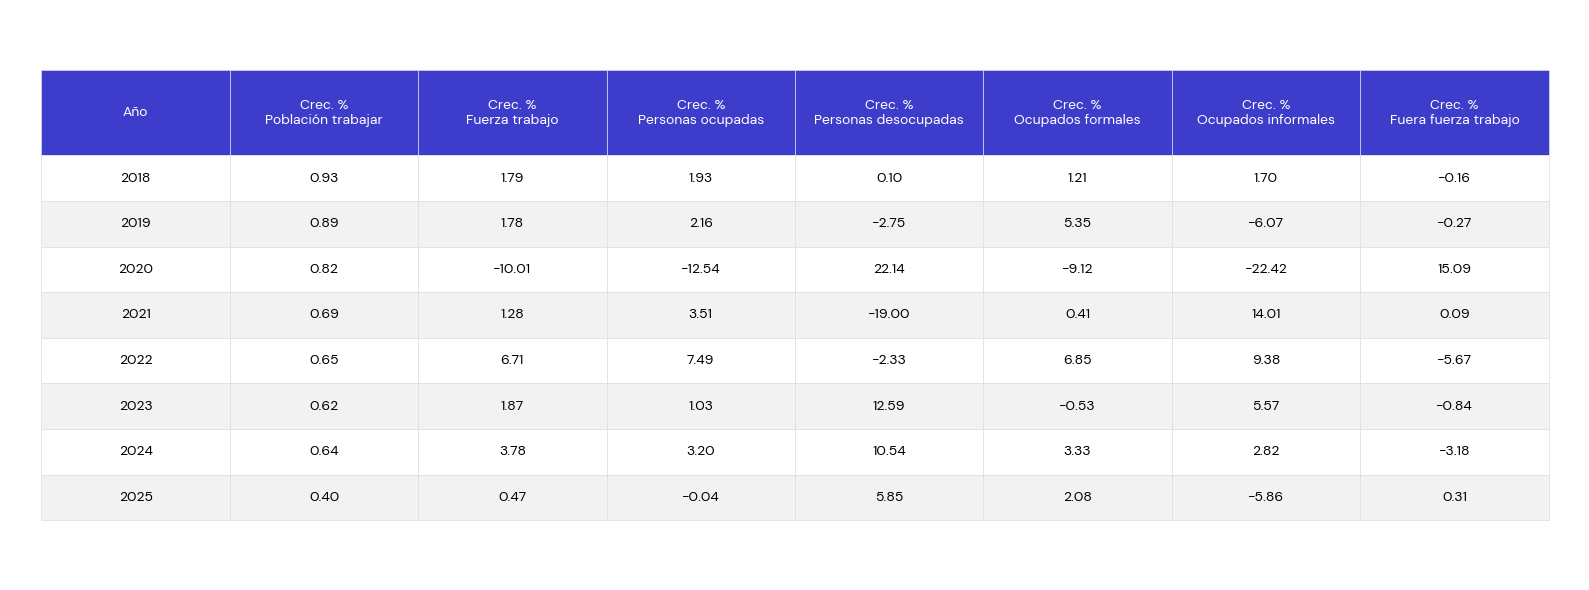

<ipython-input-79-2415737670>:147: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


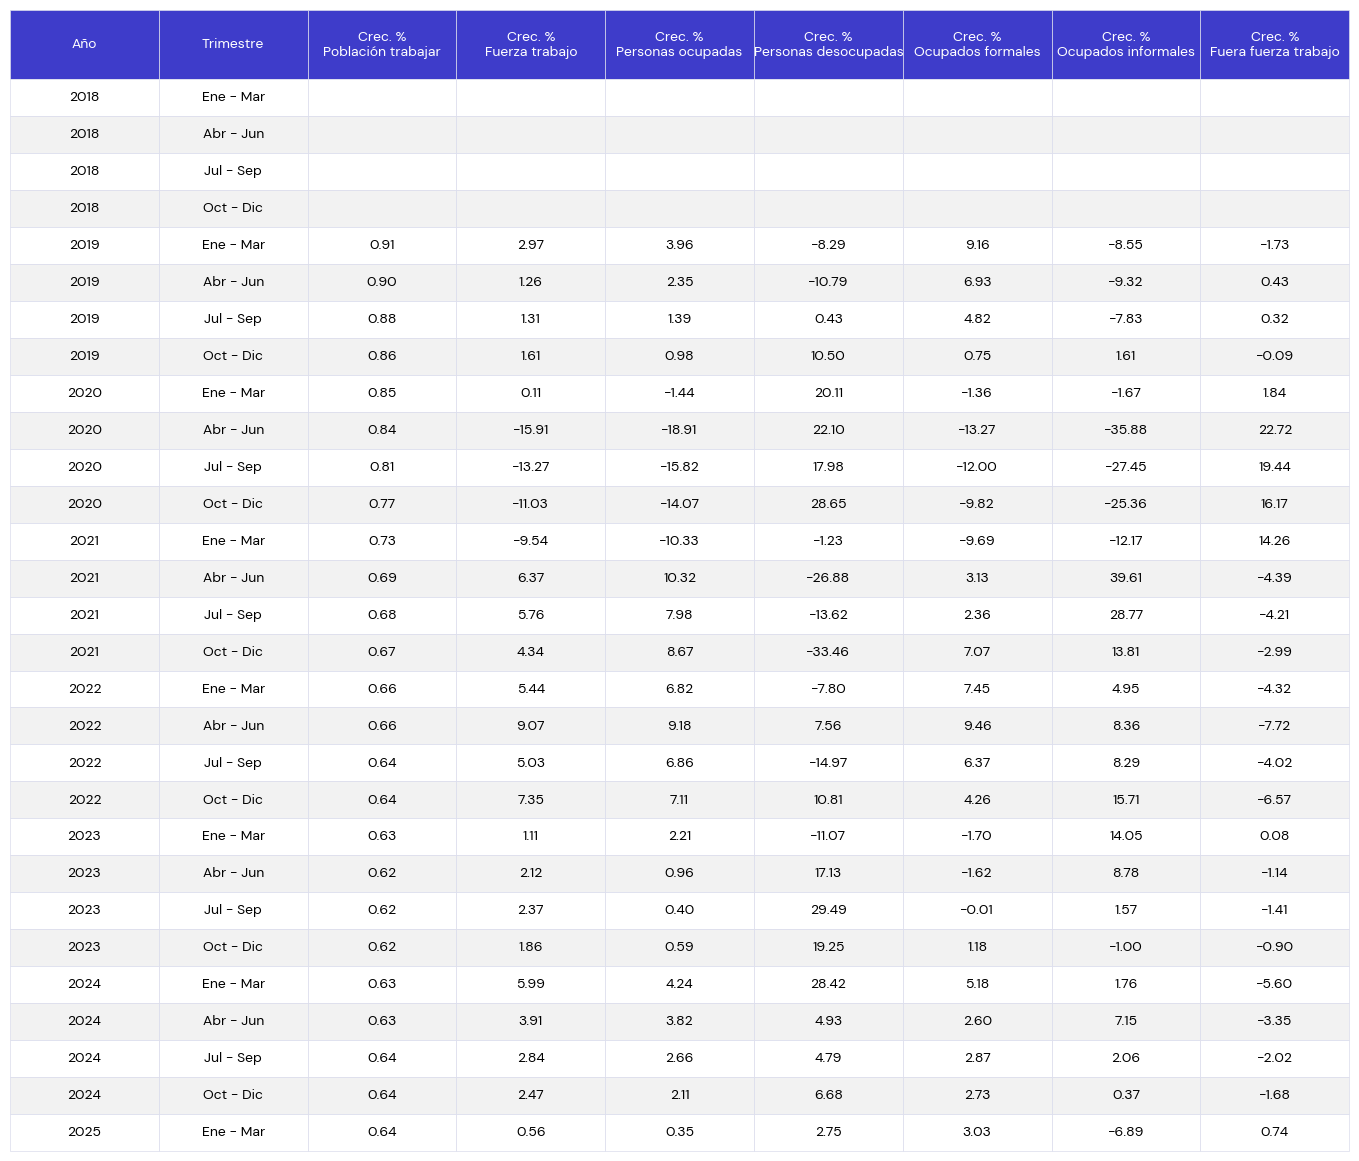

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ─── 1. Fuente personalizada (opcional) ───────────────────────────────────────
font_path = "/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf"
if Path(font_path).exists():
    fm.fontManager.addfont(font_path)
    dm_font = fm.FontProperties(fname=font_path)
else:
    dm_font = fm.FontProperties()

# ─── 2. Cargar y preparar datos ───────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df_bio = df[df["region_name"] == "Biobío"].copy()

orden_trimestres = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}
df_bio["orden"] = df_bio["Trimestre"].map(orden_trimestres)
df_bio = df_bio.sort_values(["Año", "orden"]).drop(columns="orden")

column_map = {
    "PET_indicadoresprincipales": "Población en\nedad de trabajar",
    "FT_TOT_indicadoresprincipales": "Fuerza de\ntrabajo",
    "PO_TOT_indicadoresprincipales": "Personas\nocupadas",
    "PDO_TOT_indicadoresprincipales": "Personas\ndesocupadas",
    "PO_F_TOT_informalidadrama": "Personas ocupadas\nformales",
    "PO_I_TOT_informalidadrama": "Personas ocupadas\ninformales",
    "FFT_TOT_indicadoresprincipales": "Fuera de la\nfuerza de trabajo"
}
variables = list(column_map.values())
column_keys = list(column_map.keys())

# ─── 3. Datos anuales completos ───────────────────────────────────────────────
df_anual_full = df_bio[["Año"] + column_keys].groupby("Año").mean(numeric_only=True).reset_index()
df_anual_full = df_anual_full.rename(columns=column_map)

# ─── 4. Tabla 1: Promedios anuales desde 2018, redondeados ────────────────────
df_anual = df_anual_full[df_anual_full["Año"] >= 2018].copy()
df_anual["Año"] = df_anual["Año"].astype(int).astype(str)
# Redondear correctamente y convertir a entero
for var in variables:
    df_anual[var] = df_anual[var].fillna(0).round().astype(int).astype(str)

# ─── 5. Tabla 2: Trimestral desde 2018, redondeados ───────────────────────────
df_trim = df_bio[df_bio["Año"] >= 2018][["Año", "Trimestre"] + column_keys].copy()
df_trim = df_trim.rename(columns=column_map)
# Redondear correctamente y convertir a entero
for var in variables:
    df_trim[var] = df_trim[var].fillna(0).round().astype(int).astype(str)

# ─── 6. Tabla 3: Crecimiento % anual desde base completa ──────────────────────
df_var_anual = df_anual_full.copy()
for var in variables:
    df_var_anual[f"Crecimiento % {var}"] = df_var_anual[var].pct_change() * 100

# Crear encabezados más cortos para las variaciones
var_columns_map = {
    f"Crecimiento % {variables[0]}": "Crec. %\nPoblación trabajar",
    f"Crecimiento % {variables[1]}": "Crec. %\nFuerza trabajo",
    f"Crecimiento % {variables[2]}": "Crec. %\nPersonas ocupadas",
    f"Crecimiento % {variables[3]}": "Crec. %\nPersonas desocupadas",
    f"Crecimiento % {variables[4]}": "Crec. %\nOcupados formales",
    f"Crecimiento % {variables[5]}": "Crec. %\nOcupados informales",
    f"Crecimiento % {variables[6]}": "Crec. %\nFuera fuerza trabajo"
}

df_var_anual = df_var_anual[["Año"] + [f"Crecimiento % {v}" for v in variables]]
df_var_anual = df_var_anual.rename(columns=var_columns_map)
df_var_anual = df_var_anual[df_var_anual["Año"] >= 2018].copy()
df_var_anual["Año"] = df_var_anual["Año"].astype(int).astype(str)
# Mantener 2 decimales en las variaciones
crecimiento_cols = [col for col in df_var_anual.columns if col.startswith("Crec.")]
for col in crecimiento_cols:
    df_var_anual[col] = df_var_anual[col].round(2)

# ─── 7. Tabla 4: Crecimiento % trimestral desde base completa ─────────────────
df_var_trim = df_bio[df_bio["Año"] >= 2018][["Año", "Trimestre"] + column_keys].copy()
df_var_trim = df_var_trim.rename(columns=column_map)
for var in variables:
    df_var_trim[f"Crecimiento % {var}"] = (
        df_var_trim.groupby("Trimestre")[var].pct_change() * 100
    )

# Crear encabezados más cortos para las variaciones trimestrales
var_columns_map_trim = {
    f"Crecimiento % {variables[0]}": "Crec. %\nPoblación trabajar",
    f"Crecimiento % {variables[1]}": "Crec. %\nFuerza trabajo",
    f"Crecimiento % {variables[2]}": "Crec. %\nPersonas ocupadas",
    f"Crecimiento % {variables[3]}": "Crec. %\nPersonas desocupadas",
    f"Crecimiento % {variables[4]}": "Crec. %\nOcupados formales",
    f"Crecimiento % {variables[5]}": "Crec. %\nOcupados informales",
    f"Crecimiento % {variables[6]}": "Crec. %\nFuera fuerza trabajo"
}

df_var_trim = df_var_trim[["Año", "Trimestre"] + [f"Crecimiento % {v}" for v in variables]]
df_var_trim = df_var_trim.rename(columns=var_columns_map_trim)
# Mantener 2 decimales en las variaciones trimestrales
crecimiento_cols_trim = [col for col in df_var_trim.columns if col.startswith("Crec.")]
for col in crecimiento_cols_trim:
    df_var_trim[col] = df_var_trim[col].round(2)

# ─── 8. Función para mostrar tablas como imagen ───────────────────────────────
def mostrar_tabla(df, title=""):
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.axis("off")

    # Convertir DataFrame a strings para mostrar
    df_display = df.copy()
    for col in df_display.columns:
        if col not in ["Año", "Trimestre"]:
            # Si es columna numérica, formatear apropiadamente
            if df_display[col].dtype in ['float64', 'int64', 'float32', 'int32']:
                if any('Crec.' in str(c) for c in df_display.columns):
                    # Es tabla de variaciones, mantener 2 decimales
                    df_display[col] = df_display[col].apply(lambda x: f"{x:.2f}" if pd.notna(x) else "")
                else:
                    # Es tabla de valores absolutos, sin decimales
                    df_display[col] = df_display[col].apply(lambda x: f"{int(x)}" if pd.notna(x) else "")

    tabla = ax.table(
        cellText=[df_display.columns.tolist()] + df_display.astype(str).values.tolist(),
        cellLoc='center',
        loc='center'
    )
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(11)
    tabla.scale(1.2, 2.0)

    for (row, col), cell in tabla.get_celld().items():
        if row == 0:
            cell.set_facecolor("#3E3CCA")
            cell.set_text_props(color='white', weight='bold', fontproperties=dm_font)
            cell.set_height(0.15)
        else:
            cell.set_facecolor("white" if row % 2 else "#f2f2f2")
            cell.set_text_props(fontproperties=dm_font)
            cell.set_height(0.08)
        cell.set_edgecolor("#DADCEC")
        cell.set_linewidth(0.5)
        cell.set_width(0.12)

    if title:
        plt.title(title, fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

# ─── 9. Mostrar todas las tablas ──────────────────────────────────────────────
mostrar_tabla(df_anual)
mostrar_tabla(df_trim)
mostrar_tabla(df_var_anual)
mostrar_tabla(df_var_trim)

# Gráficos linea y barras

🔍 Buscando fuentes DM Sans en Google Drive...
   📁 Revisando: /content/drive/MyDrive/Data/fonts
   ✅ Encontrada: DMSans-Regular.ttf
   ✅ Encontrada: DMSans-Bold.ttf
   ✅ Encontrada: DMSans-Italic.ttf
✅ Registrada: DMSans-Regular.ttf → 'DM Sans'
✅ Registrada: DMSans-Bold.ttf → 'DM Sans'
✅ Registrada: DMSans-Italic.ttf → 'DM Sans'

🎯 Configurando 'DM Sans' como fuente principal
✅ DM Sans configurado exitosamente


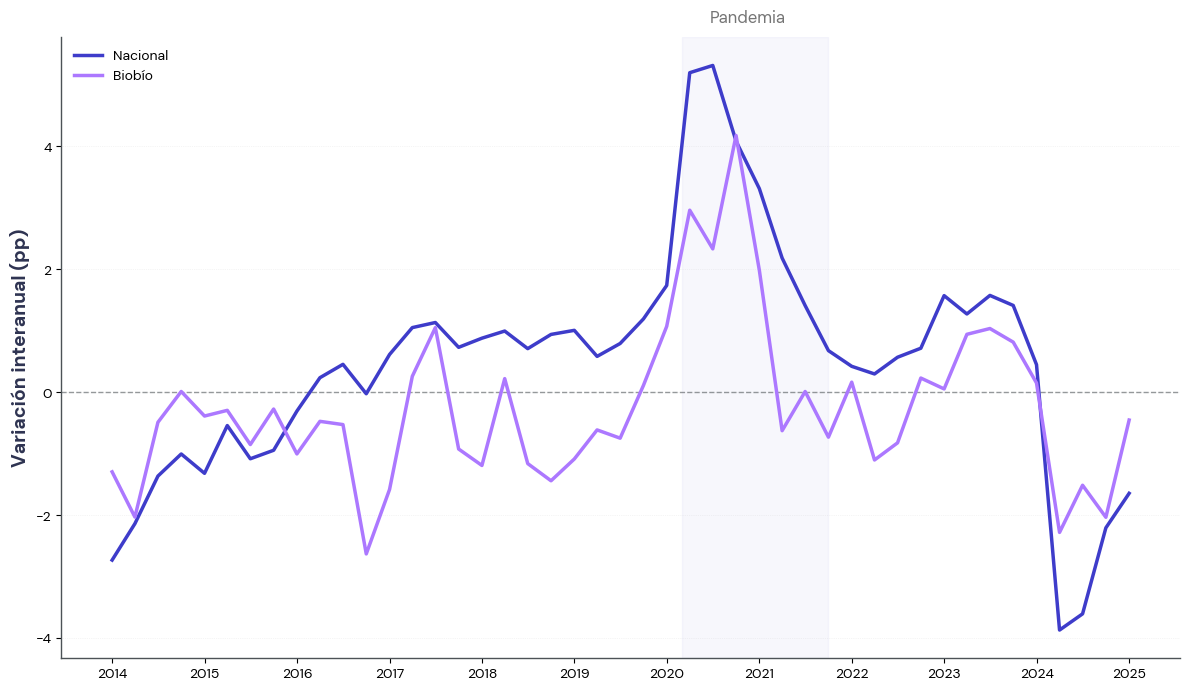


🎨 Fuente configurada: DM Sans
🎨 Fuente en título: DM Sans
📊 Total fuentes registradas: 3


In [ ]:
# ─── 1. Cargar DM Sans desde Google Drive ─────────────────────────────────────
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Rutas donde buscar las fuentes DM Sans en tu Drive
FONT_PATHS = [
    "/content/drive/MyDrive/Data/fonts/",  # Carpeta fonts en Data
]

# Nombres de archivos de fuente a buscar
FONT_FILES = [
    "DMSans-Regular.ttf",
    "DMSans-Bold.ttf",
    "DMSans-Italic.ttf",
]

print("🔍 Buscando fuentes DM Sans en Google Drive...")
found_fonts = []

# Buscar fuentes en las rutas especificadas
for base_path in FONT_PATHS:
    font_dir = Path(base_path)
    if font_dir.exists():
        print(f"   📁 Revisando: {font_dir}")
        for font_file in FONT_FILES:
            font_path = font_dir / font_file
            if font_path.exists():
                found_fonts.append(font_path)
                print(f"   ✅ Encontrada: {font_file}")
    else:
        print(f"   ⚠️ No existe: {font_dir}")

# ─── 2. Registrar fuentes encontradas ──────────────────────────────────────────
registered_fonts = []
dm_font_name = None

for font_path in found_fonts:
    try:
        # Registrar la fuente
        fm.fontManager.addfont(str(font_path))
        registered_fonts.append(font_path)

        # Obtener el nombre real de la fuente
        font_props = fm.FontProperties(fname=str(font_path))
        font_name = font_props.get_name()

        if not dm_font_name:  # Usar la primera fuente como principal
            dm_font_name = font_name

        print(f"✅ Registrada: {font_path.name} → '{font_name}'")

    except Exception as e:
        print(f"❌ Error registrando {font_path.name}: {e}")

# ─── 3. Configurar matplotlib para usar DM Sans ───────────────────────────────
if dm_font_name:
    print(f"\n🎯 Configurando '{dm_font_name}' como fuente principal")

    # Método 1: Configurar rcParams
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': [dm_font_name, 'DejaVu Sans', 'Arial', 'Liberation Sans']
    })

    # Método 2: Crear FontProperties para uso directo
    dm_font_props = fm.FontProperties(family=dm_font_name)
    dm_font_bold = fm.FontProperties(family=dm_font_name, weight='bold')

    print("✅ DM Sans configurado exitosamente")


# ─── 4. Configuración de datos y paleta ───────────────────────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png")

PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 5. Cargar y procesar datos ────────────────────────────────────────────────
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# Extraer trimestre móvil
df["Trimestre"] = df["Fecha"].dt.strftime("%b-%Y")

def variacion_interanual_pp(df_region):
    df_region = df_region.sort_values("Fecha").copy()
    df_region["Trimestre"] = df_region["Fecha"].dt.strftime("%b")
    df_region["var"] = (
        df_region.groupby("Trimestre")["T_TDO_indicadoresprincipales"]
        .transform(lambda s: s - s.shift(4))
    )
    return df_region

nac = variacion_interanual_pp(df[df["region_name"] == "Nacional"].copy())
bio = variacion_interanual_pp(df[df["region_name"] == "Biobío"].copy())

# ─── 6. Crear gráfico con DM Sans ──────────────────────────────────────────────

import matplotlib.dates as mdates
from matplotlib.dates import date2num

fig, ax = plt.subplots(figsize=(12, 7))

# Pandemia: sombreado
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Líneas
ax.plot(nac["Fecha"], nac["var"], label="Nacional", color=PALETTE[3], linewidth=2.5, zorder=2)
ax.plot(bio["Fecha"], bio["var"], label="Biobío", color=PALETTE[6], linewidth=2.5, zorder=2)

# Línea 0
ax.axhline(0, color=PALETTE[0], linestyle="--", linewidth=1, alpha=0.6, zorder=1)

# Texto pandemia
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.03,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center", va="bottom",
    color="#666666", alpha=0.9
)

# Ejes
ax.set_ylabel("Variación interanual (pp)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Fuente en ticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Estética
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Leyenda
ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font_props)

plt.tight_layout()
plt.show()



# ─── 7. Verificar fuente y mostrar ─────────────────────────────────────────────
print(f"\n🎨 Fuente configurada: {dm_font_name}")
print(f"🎨 Fuente en título: {ax.title.get_fontname()}")
print(f"📊 Total fuentes registradas: {len(registered_fonts)}")

plt.show()



🔍 Buscando fuentes DM Sans en Google Drive...
   📁 Revisando: /content/drive/MyDrive/Data/fonts
   ✅ Encontrada: DMSans-Regular.ttf
   ✅ Encontrada: DMSans-Bold.ttf
   ✅ Encontrada: DMSans-Italic.ttf
✅ Registrada: DMSans-Regular.ttf → 'DM Sans'
✅ Registrada: DMSans-Bold.ttf → 'DM Sans'
✅ Registrada: DMSans-Italic.ttf → 'DM Sans'

🎯 Configurando 'DM Sans' como fuente principal
✅ DM Sans configurado exitosamente

🎨 Fuente configurada: DM Sans
📊 Total fuentes registradas: 3


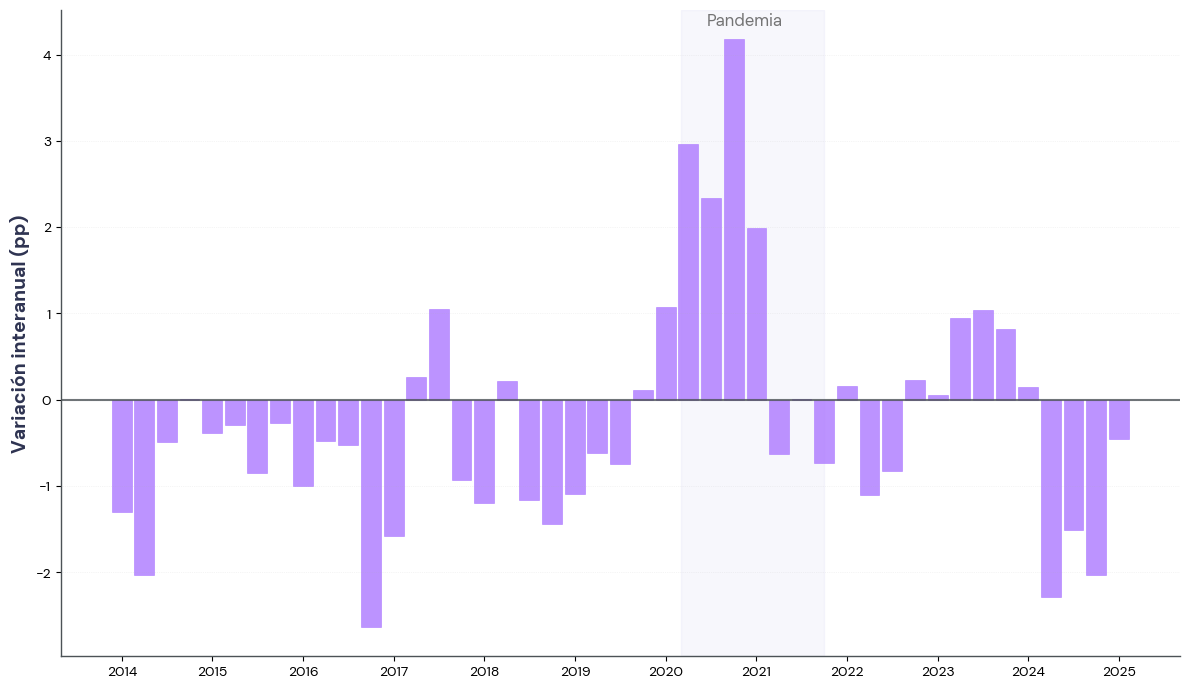

In [ ]:
# ─── 1. Cargar DM Sans desde Google Drive ─────────────────────────────────────
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Rutas donde buscar las fuentes DM Sans en tu Drive
FONT_PATHS = [
    "/content/drive/MyDrive/Data/fonts/",  # Carpeta fonts en Data
]

# Nombres de archivos de fuente a buscar
FONT_FILES = [
    "DMSans-Regular.ttf",
    "DMSans-Bold.ttf",
    "DMSans-Italic.ttf",
]

print("🔍 Buscando fuentes DM Sans en Google Drive...")
found_fonts = []

# Buscar fuentes en las rutas especificadas
for base_path in FONT_PATHS:
    font_dir = Path(base_path)
    if font_dir.exists():
        print(f"   📁 Revisando: {font_dir}")
        for font_file in FONT_FILES:
            font_path = font_dir / font_file
            if font_path.exists():
                found_fonts.append(font_path)
                print(f"   ✅ Encontrada: {font_file}")
    else:
        print(f"   ⚠️ No existe: {font_dir}")

# ─── 2. Registrar fuentes encontradas ──────────────────────────────────────────
registered_fonts = []
dm_font_name = None

for font_path in found_fonts:
    try:
        # Registrar la fuente
        fm.fontManager.addfont(str(font_path))
        registered_fonts.append(font_path)

        # Obtener el nombre real de la fuente
        font_props = fm.FontProperties(fname=str(font_path))
        font_name = font_props.get_name()

        if not dm_font_name:  # Usar la primera fuente como principal
            dm_font_name = font_name

        print(f"✅ Registrada: {font_path.name} → '{font_name}'")

    except Exception as e:
        print(f"❌ Error registrando {font_path.name}: {e}")

# ─── 3. Configurar matplotlib para usar DM Sans ───────────────────────────────
if dm_font_name:
    print(f"\n🎯 Configurando '{dm_font_name}' como fuente principal")

    # Método 1: Configurar rcParams
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': [dm_font_name, 'DejaVu Sans', 'Arial', 'Liberation Sans']
    })

    # Método 2: Crear FontProperties para uso directo
    dm_font_props = fm.FontProperties(family=dm_font_name)
    dm_font_bold = fm.FontProperties(family=dm_font_name, weight='bold')

    print("✅ DM Sans configurado exitosamente")


# ─── 4. Configuración de datos y paleta ───────────────────────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo_barras.png")

PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 5. Cargar y procesar datos ────────────────────────────────────────────────
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# Extraer trimestre móvil
df["Trimestre"] = df["Fecha"].dt.strftime("%b-%Y")

def variacion_interanual_pp(df_region):
    df_region = df_region.sort_values("Fecha").copy()
    df_region["Trimestre"] = df_region["Fecha"].dt.strftime("%b")
    df_region["var"] = (
        df_region.groupby("Trimestre")["T_TDO_indicadoresprincipales"]
        .transform(lambda s: s - s.shift(4))
    )
    return df_region

# Solo procesar Biobío
bio = variacion_interanual_pp(df[df["region_name"] == "Biobío"].copy())

# ─── 6. Crear gráfico de barras con DM Sans ───────────────────────────────────

import matplotlib.dates as mdates
from matplotlib.dates import date2num

fig, ax = plt.subplots(figsize=(12, 7))

# Crear barras
bars = ax.bar(bio["Fecha"], bio["var"],
              color=PALETTE[6], alpha=0.8,
              width=80, edgecolor=PALETTE[6], linewidth=0.5)

# Colorear barras según valor (positivo/negativo)
for i, (bar, val) in enumerate(zip(bars, bio["var"])):
    if val >= 0:
        bar.set_color(PALETTE[6])  # Color principal para positivos
    else:
        bar.set_color(PALETTE[6])  # Color alternativo para negativos

# Pandemia: sombreado
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Línea 0
ax.axhline(0, color=PALETTE[0], linestyle="-", linewidth=1.5, alpha=0.8, zorder=3)

# Texto pandemia
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 0.95,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center", va="bottom",
    color="#666666", alpha=0.9
)

# Ejes
ax.set_ylabel("Variación interanual (pp)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Fuente en ticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Estética
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)


plt.tight_layout()

# ─── 7. Verificar fuente y mostrar ─────────────────────────────────────────────
print(f"\n🎨 Fuente configurada: {dm_font_name}")
print(f"📊 Total fuentes registradas: {len(registered_fonts)}")

plt.show()

# Opcional: Guardar el gráfico
# plt.savefig(OUT_FILE, dpi=300, bbox_inches='tight', facecolor='white')

🔍 Buscando fuentes DM Sans en Google Drive...
   📁 Revisando: /content/drive/MyDrive/Data/fonts
   ✅ Encontrada: DMSans-Regular.ttf
   ✅ Encontrada: DMSans-Bold.ttf
   ✅ Encontrada: DMSans-Italic.ttf
✅ Registrada: DMSans-Regular.ttf → 'DM Sans'
✅ Registrada: DMSans-Bold.ttf → 'DM Sans'
✅ Registrada: DMSans-Italic.ttf → 'DM Sans'

🎯 Configurando 'DM Sans' como fuente principal
✅ DM Sans configurado exitosamente

🎨 Fuente configurada: DM Sans
📊 Total fuentes registradas: 3

📋 Datos procesados:
Año | TDO Promedio | Cambio (pp)
-----------------------------------
2011 | 8.33% | -1.15
2012 | 8.47% | +0.14
2013 | 8.05% | -0.42
2014 | 8.52% | +0.47
2015 | 7.87% | -0.65
2016 | 7.31% | -0.56
2017 | 7.76% | +0.44
2018 | 7.63% | -0.12
2019 | 7.29% | -0.34
2020 | 9.95% | +2.66
2021 | 7.92% | -2.03
2022 | 7.25% | -0.67
2023 | 8.00% | +0.75
2024 | 8.53% | +0.53
2025 | 8.98% | +0.46


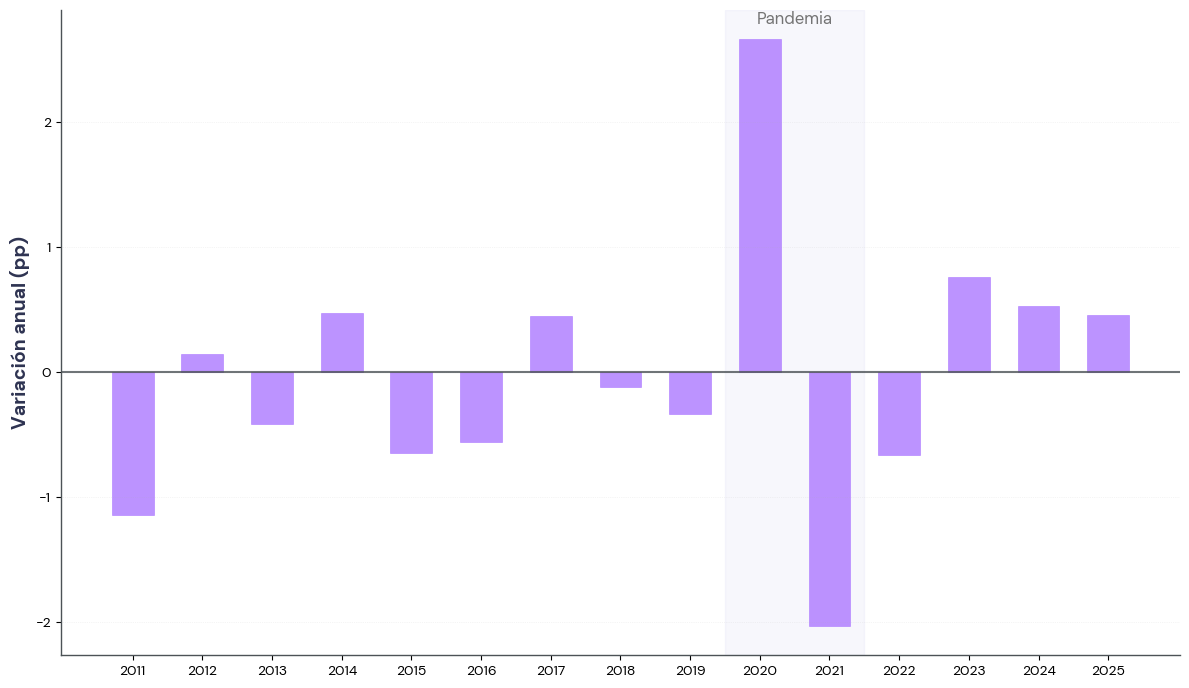

In [ ]:
# ─── 1. Cargar DM Sans desde Google Drive ─────────────────────────────────────
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Rutas donde buscar las fuentes DM Sans en tu Drive
FONT_PATHS = [
    "/content/drive/MyDrive/Data/fonts/",  # Carpeta fonts en Data
]

# Nombres de archivos de fuente a buscar
FONT_FILES = [
    "DMSans-Regular.ttf",
    "DMSans-Bold.ttf",
    "DMSans-Italic.ttf",
]

print("🔍 Buscando fuentes DM Sans en Google Drive...")
found_fonts = []

# Buscar fuentes en las rutas especificadas
for base_path in FONT_PATHS:
    font_dir = Path(base_path)
    if font_dir.exists():
        print(f"   📁 Revisando: {font_dir}")
        for font_file in FONT_FILES:
            font_path = font_dir / font_file
            if font_path.exists():
                found_fonts.append(font_path)
                print(f"   ✅ Encontrada: {font_file}")
    else:
        print(f"   ⚠️ No existe: {font_dir}")

# ─── 2. Registrar fuentes encontradas ──────────────────────────────────────────
registered_fonts = []
dm_font_name = None

for font_path in found_fonts:
    try:
        # Registrar la fuente
        fm.fontManager.addfont(str(font_path))
        registered_fonts.append(font_path)

        # Obtener el nombre real de la fuente
        font_props = fm.FontProperties(fname=str(font_path))
        font_name = font_props.get_name()

        if not dm_font_name:  # Usar la primera fuente como principal
            dm_font_name = font_name

        print(f"✅ Registrada: {font_path.name} → '{font_name}'")

    except Exception as e:
        print(f"❌ Error registrando {font_path.name}: {e}")

# ─── 3. Configurar matplotlib para usar DM Sans ───────────────────────────────
if dm_font_name:
    print(f"\n🎯 Configurando '{dm_font_name}' como fuente principal")

    # Método 1: Configurar rcParams
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': [dm_font_name, 'DejaVu Sans', 'Arial', 'Liberation Sans']
    })

    # Método 2: Crear FontProperties para uso directo
    dm_font_props = fm.FontProperties(family=dm_font_name)
    dm_font_bold = fm.FontProperties(family=dm_font_name, weight='bold')

    print("✅ DM Sans configurado exitosamente")


# ─── 4. Configuración de datos y paleta ───────────────────────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo_barras.png")

PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 5. Cargar y procesar datos ────────────────────────────────────────────────
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# Filtrar solo Biobío
bio_df = df[df["region_name"] == "Biobío"].copy()

# Extraer año
bio_df["Año"] = bio_df["Fecha"].dt.year

# Calcular promedio anual del TDO por año
bio_anual = bio_df.groupby("Año")["T_TDO_indicadoresprincipales"].mean().reset_index()
bio_anual.columns = ["Año", "TDO_promedio"]

# Calcular cambio interanual en puntos porcentuales
bio_anual["cambio_pp"] = bio_anual["TDO_promedio"].diff()

# Eliminar el primer año (no tiene cambio)
bio = bio_anual.dropna().copy()

# ─── 6. Crear gráfico de barras con DM Sans ───────────────────────────────────

fig, ax = plt.subplots(figsize=(12, 7))

# Crear barras
bars = ax.bar(bio["Año"], bio["cambio_pp"],
              color=PALETTE[6], alpha=0.8,
              width=0.6, edgecolor=PALETTE[6], linewidth=0.5)

# Colorear barras según valor (positivo/negativo)
for i, (bar, val) in enumerate(zip(bars, bio["cambio_pp"])):
    if val >= 0:
        bar.set_color(PALETTE[6])  # Color principal para positivos
    else:
        bar.set_color(PALETTE[6])  # Color alternativo para negativos

# Pandemia: sombreado (años 2020-2021)
ax.axvspan(2019.5, 2021.5, color="#3e3cca", alpha=0.04, zorder=0)

# Línea 0
ax.axhline(0, color=PALETTE[0], linestyle="-", linewidth=1.5, alpha=0.8, zorder=3)

# Texto pandemia
ax.text(2020.5, ax.get_ylim()[1] * 0.95, "Pandemia",
        fontproperties=dm_font_props, fontsize=12,
        ha="center", va="bottom", color="#666666", alpha=0.9)

# Ejes
ax.set_ylabel("Variación anual (pp)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.set_xlabel("")

# Configurar eje X para años
ax.set_xticks(bio["Año"])
ax.set_xticklabels([str(int(año)) for año in bio["Año"]])
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Fuente en ticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Estética
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)


plt.tight_layout()

# ─── 7. Verificar fuente, mostrar datos y gráfico ──────────────────────────────
print(f"\n🎨 Fuente configurada: {dm_font_name}")
print(f"📊 Total fuentes registradas: {len(registered_fonts)}")

# Mostrar tabla de datos
print(f"\n📋 Datos procesados:")
print("Año | TDO Promedio | Cambio (pp)")
print("-" * 35)
for _, row in bio.iterrows():
    print(f"{int(row['Año'])} | {row['TDO_promedio']:.2f}% | {row['cambio_pp']:+.2f}")

plt.show()

# Opcional: Guardar el gráfico
# plt.savefig(OUT_FILE, dpi=300, bbox_inches='tight', facecolor='white')

🔍 Buscando fuentes DM Sans en Google Drive...
   📁 Revisando: /content/drive/MyDrive/Data/fonts
   ✅ Encontrada: DMSans-Regular.ttf
   ✅ Encontrada: DMSans-Bold.ttf
   ✅ Encontrada: DMSans-Italic.ttf
✅ Registrada: DMSans-Regular.ttf → 'DM Sans'
✅ Registrada: DMSans-Bold.ttf → 'DM Sans'
✅ Registrada: DMSans-Italic.ttf → 'DM Sans'

🎯 Configurando 'DM Sans' como fuente principal
✅ DM Sans configurado exitosamente

🎨 Fuente configurada: DM Sans
📊 Total fuentes registradas: 3


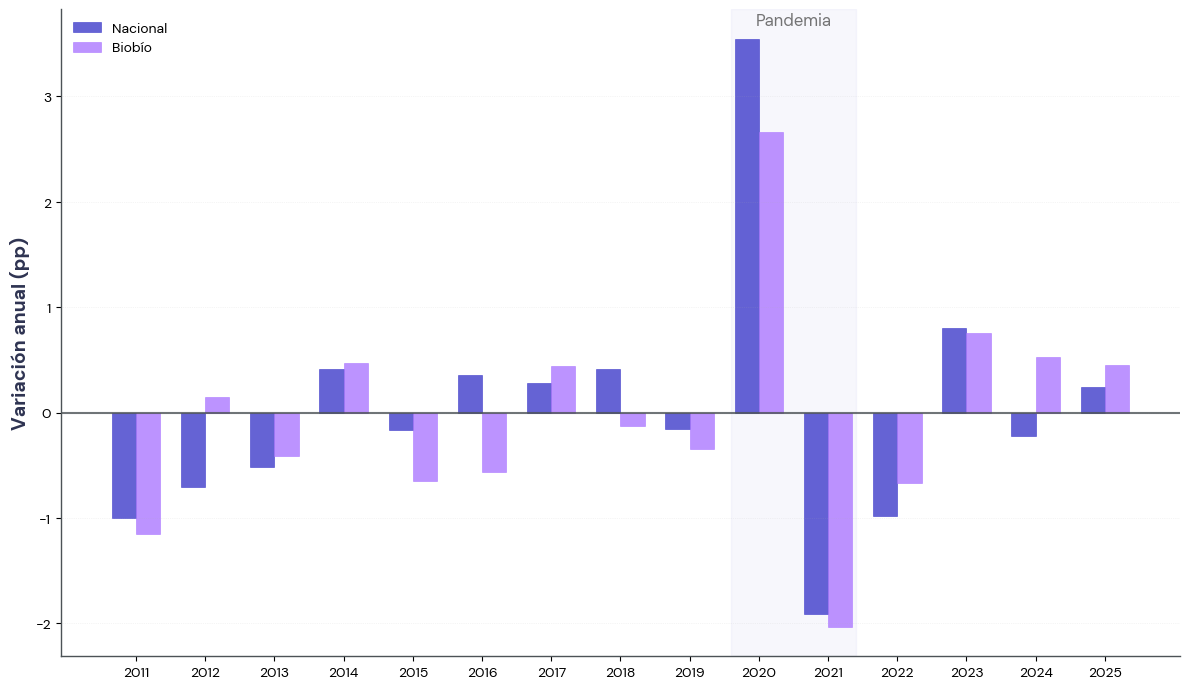

In [ ]:
# ─── 1. Cargar DM Sans desde Google Drive ─────────────────────────────────────
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Rutas donde buscar las fuentes DM Sans en tu Drive
FONT_PATHS = [
    "/content/drive/MyDrive/Data/fonts/",  # Carpeta fonts en Data
]

# Nombres de archivos de fuente a buscar
FONT_FILES = [
    "DMSans-Regular.ttf",
    "DMSans-Bold.ttf",
    "DMSans-Italic.ttf",
]

print("🔍 Buscando fuentes DM Sans en Google Drive...")
found_fonts = []

# Buscar fuentes en las rutas especificadas
for base_path in FONT_PATHS:
    font_dir = Path(base_path)
    if font_dir.exists():
        print(f"   📁 Revisando: {font_dir}")
        for font_file in FONT_FILES:
            font_path = font_dir / font_file
            if font_path.exists():
                found_fonts.append(font_path)
                print(f"   ✅ Encontrada: {font_file}")
    else:
        print(f"   ⚠️ No existe: {font_dir}")

# ─── 2. Registrar fuentes encontradas ──────────────────────────────────────────
registered_fonts = []
dm_font_name = None

for font_path in found_fonts:
    try:
        # Registrar la fuente
        fm.fontManager.addfont(str(font_path))
        registered_fonts.append(font_path)

        # Obtener el nombre real de la fuente
        font_props = fm.FontProperties(fname=str(font_path))
        font_name = font_props.get_name()

        if not dm_font_name:  # Usar la primera fuente como principal
            dm_font_name = font_name

        print(f"✅ Registrada: {font_path.name} → '{font_name}'")

    except Exception as e:
        print(f"❌ Error registrando {font_path.name}: {e}")

# ─── 3. Configurar matplotlib para usar DM Sans ───────────────────────────────
if dm_font_name:
    print(f"\n🎯 Configurando '{dm_font_name}' como fuente principal")

    # Método 1: Configurar rcParams
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': [dm_font_name, 'DejaVu Sans', 'Arial', 'Liberation Sans']
    })

    # Método 2: Crear FontProperties para uso directo
    dm_font_props = fm.FontProperties(family=dm_font_name)
    dm_font_bold = fm.FontProperties(family=dm_font_name, weight='bold')

    print("✅ DM Sans configurado exitosamente")


# ─── 4. Configuración de datos y paleta ───────────────────────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo_barras.png")

PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 5. Cargar y procesar datos ────────────────────────────────────────────────
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# Extraer año
df["Año"] = df["Fecha"].dt.year

# Procesar tanto Nacional como Biobío
def procesar_region(df_region, region_name):
    # Calcular promedio anual del TDO por año
    anual = df_region.groupby("Año")["T_TDO_indicadoresprincipales"].mean().reset_index()
    anual.columns = ["Año", "TDO_promedio"]

    # Calcular cambio interanual en puntos porcentuales
    anual["cambio_pp"] = anual["TDO_promedio"].diff()
    anual["region"] = region_name

    # Eliminar el primer año (no tiene cambio)
    return anual.dropna().copy()

# Procesar ambas regiones
nac = procesar_region(df[df["region_name"] == "Nacional"].copy(), "Nacional")
bio = procesar_region(df[df["region_name"] == "Biobío"].copy(), "Biobío")

# Combinar datos
datos_combinados = pd.concat([nac, bio], ignore_index=True)

# ─── 6. Crear gráfico de barras comparativo con DM Sans ──────────────────────

fig, ax = plt.subplots(figsize=(12, 7))

# Preparar datos para barras agrupadas
años = nac["Año"].values
x_pos = np.arange(len(años))
width = 0.35

# Crear barras agrupadas
bars_nac = ax.bar(x_pos - width/2, nac["cambio_pp"], width,
                  label="Nacional", color=PALETTE[3], alpha=0.8,
                  edgecolor=PALETTE[3], linewidth=0.5)

bars_bio = ax.bar(x_pos + width/2, bio["cambio_pp"], width,
                  label="Biobío", color=PALETTE[6], alpha=0.8,
                  edgecolor=PALETTE[6], linewidth=0.5)


# Pandemia: sombreado
# Encontrar posiciones de 2020 y 2021
años_list = list(años)
if 2020 in años_list and 2021 in años_list:
    pos_2020 = años_list.index(2020)
    pos_2021 = años_list.index(2021)
    ax.axvspan(pos_2020 - 0.4, pos_2021 + 0.4,
               color="#3e3cca", alpha=0.04, zorder=0)

# Línea 0
ax.axhline(0, color=PALETTE[0], linestyle="-", linewidth=1.5, alpha=0.8, zorder=3)

# Texto pandemia
if 2020 in años_list:
    pos_pandemia = años_list.index(2020) + 0.5
    ax.text(pos_pandemia, ax.get_ylim()[1] * 0.95, "Pandemia",
            fontproperties=dm_font_props, fontsize=12,
            ha="center", va="bottom", color="#666666", alpha=0.9)

# Ejes
ax.set_ylabel("Variación anual (pp)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.set_xlabel("")

# Configurar eje X
ax.set_xticks(x_pos)
ax.set_xticklabels([str(int(año)) for año in años])
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Fuente en ticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Estética
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Leyenda
ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font_props)


plt.tight_layout()

# ─── 7. Verificar fuente, mostrar datos y gráfico ──────────────────────────────
print(f"\n🎨 Fuente configurada: {dm_font_name}")
print(f"📊 Total fuentes registradas: {len(registered_fonts)}")


plt.show()

# Opcional: Guardar el gráfico
# plt.savefig(OUT_FILE, dpi=300, bbox_inches='tight', facecolor='white')

🔍 Buscando fuentes DM Sans en Google Drive...
   📁 Revisando: /content/drive/MyDrive/Data/fonts
   ✅ Encontrada: DMSans-Regular.ttf
   ✅ Encontrada: DMSans-Bold.ttf
   ✅ Encontrada: DMSans-Italic.ttf
✅ Registrada: DMSans-Regular.ttf → 'DM Sans'
✅ Registrada: DMSans-Bold.ttf → 'DM Sans'
✅ Registrada: DMSans-Italic.ttf → 'DM Sans'

🎯 Configurando 'DM Sans' como fuente principal
✅ DM Sans configurado exitosamente


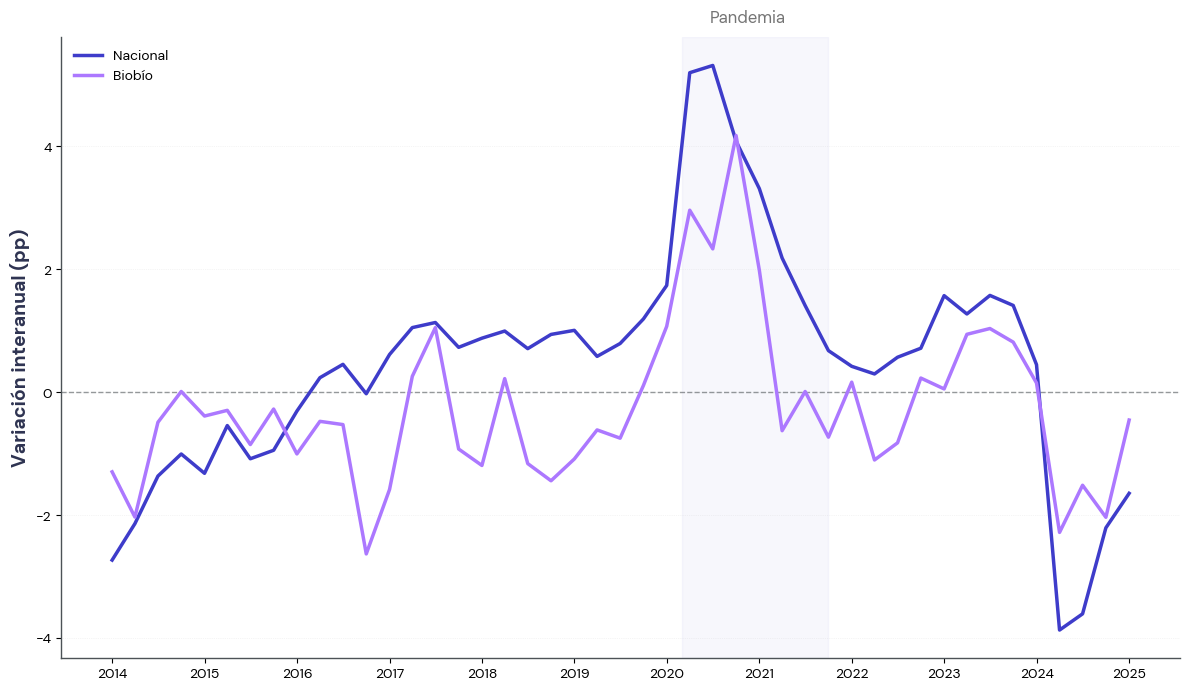


🎨 Fuente configurada: DM Sans
🎨 Fuente en título: DM Sans
📊 Total fuentes registradas: 3
✅ Gráfico guardado: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png


<Figure size 640x480 with 0 Axes>

In [ ]:

# ─── 1. Cargar DM Sans desde Google Drive ─────────────────────────────────────
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Rutas donde buscar las fuentes DM Sans en tu Drive
FONT_PATHS = [
    "/content/drive/MyDrive/Data/fonts/",  # Carpeta fonts en Data
]

# Nombres de archivos de fuente a buscar
FONT_FILES = [
    "DMSans-Regular.ttf",
    "DMSans-Bold.ttf",
    "DMSans-Italic.ttf",
]

print("🔍 Buscando fuentes DM Sans en Google Drive...")
found_fonts = []

# Buscar fuentes en las rutas especificadas
for base_path in FONT_PATHS:
    font_dir = Path(base_path)
    if font_dir.exists():
        print(f"   📁 Revisando: {font_dir}")
        for font_file in FONT_FILES:
            font_path = font_dir / font_file
            if font_path.exists():
                found_fonts.append(font_path)
                print(f"   ✅ Encontrada: {font_file}")
    else:
        print(f"   ⚠️ No existe: {font_dir}")

# ─── 2. Registrar fuentes encontradas ──────────────────────────────────────────
registered_fonts = []
dm_font_name = None

for font_path in found_fonts:
    try:
        # Registrar la fuente
        fm.fontManager.addfont(str(font_path))
        registered_fonts.append(font_path)

        # Obtener el nombre real de la fuente
        font_props = fm.FontProperties(fname=str(font_path))
        font_name = font_props.get_name()

        if not dm_font_name:  # Usar la primera fuente como principal
            dm_font_name = font_name

        print(f"✅ Registrada: {font_path.name} → '{font_name}'")

    except Exception as e:
        print(f"❌ Error registrando {font_path.name}: {e}")

# ─── 3. Configurar matplotlib para usar DM Sans ───────────────────────────────
if dm_font_name:
    print(f"\n🎯 Configurando '{dm_font_name}' como fuente principal")

    # Método 1: Configurar rcParams
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': [dm_font_name, 'DejaVu Sans', 'Arial', 'Liberation Sans']
    })

    # Método 2: Crear FontProperties para uso directo
    dm_font_props = fm.FontProperties(family=dm_font_name)
    dm_font_bold = fm.FontProperties(family=dm_font_name, weight='bold')

    print("✅ DM Sans configurado exitosamente")


# ─── 4. Configuración de datos y paleta ───────────────────────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png")

PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 5. Cargar y procesar datos ────────────────────────────────────────────────
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# Extraer trimestre móvil
df["Trimestre"] = df["Fecha"].dt.strftime("%b-%Y")

def variacion_interanual_pp(df_region):
    df_region = df_region.sort_values("Fecha").copy()
    df_region["Trimestre"] = df_region["Fecha"].dt.strftime("%b")
    df_region["var"] = (
        df_region.groupby("Trimestre")["T_TDO_indicadoresprincipales"]
        .transform(lambda s: s - s.shift(4))
    )
    return df_region

nac = variacion_interanual_pp(df[df["region_name"] == "Nacional"].copy())
bio = variacion_interanual_pp(df[df["region_name"] == "Biobío"].copy())

# ─── 6. Crear gráfico con DM Sans ──────────────────────────────────────────────

import matplotlib.dates as mdates
from matplotlib.dates import date2num

fig, ax = plt.subplots(figsize=(12, 7))

# Pandemia: sombreado
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Líneas
ax.plot(nac["Fecha"], nac["var"], label="Nacional", color=PALETTE[3], linewidth=2.5, zorder=2)
ax.plot(bio["Fecha"], bio["var"], label="Biobío", color=PALETTE[6], linewidth=2.5, zorder=2)

# Línea 0
ax.axhline(0, color=PALETTE[0], linestyle="--", linewidth=1, alpha=0.6, zorder=1)

# Texto pandemia
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.03,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center", va="bottom",
    color="#666666", alpha=0.9
)

# Ejes
ax.set_ylabel("Variación interanual (pp)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Fuente en ticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Estética
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Leyenda
ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font_props)

plt.tight_layout()
plt.show()



# ─── 7. Verificar fuente y mostrar ─────────────────────────────────────────────
print(f"\n🎨 Fuente configurada: {dm_font_name}")
print(f"🎨 Fuente en título: {ax.title.get_fontname()}")
print(f"📊 Total fuentes registradas: {len(registered_fonts)}")

plt.show()



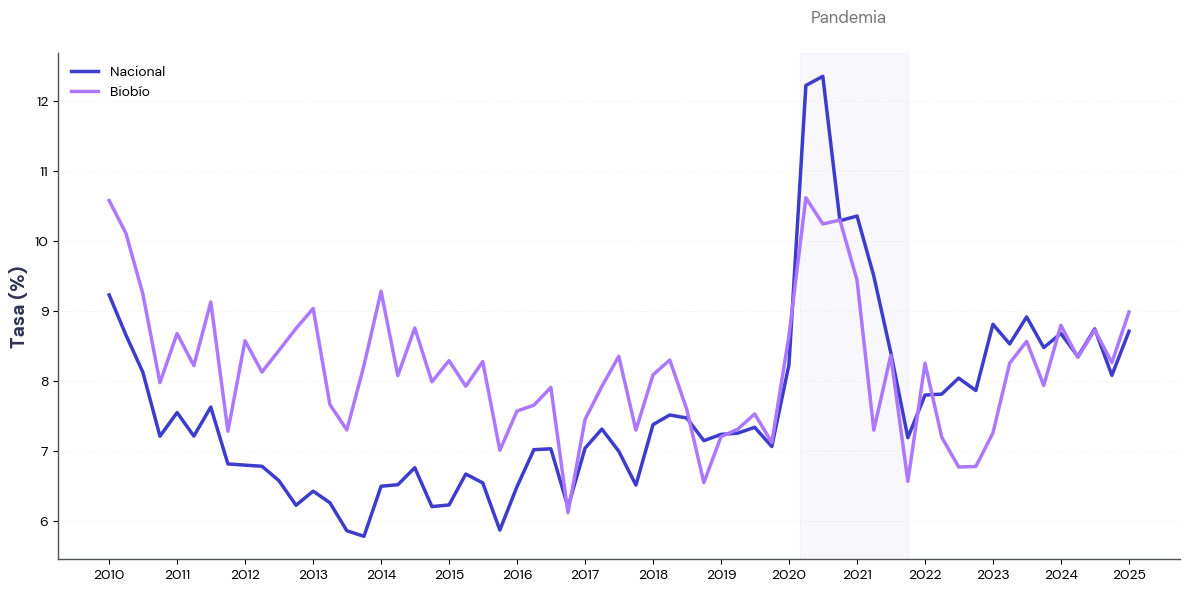

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})


# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar Nacional y Biobío ────────────────────────────────────────────────
df_nac = df[df["region_name"] == "Nacional"]
df_bio = df[df["region_name"] == "Biobío"]

import matplotlib.dates as mdates
from matplotlib.dates import date2num

# ─── Crear gráfico ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado leve para pandemia (muy tenue y atrás)
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Líneas
ax.plot(df_nac["Fecha"], df_nac["T_TDO_indicadoresprincipales"],label="Nacional", color="#3e3cca", linewidth=2.5)
ax.plot(df_bio["Fecha"], df_bio["T_TDO_indicadoresprincipales"],label="Biobío", color="#ac78ff", linewidth=2.5)


# Texto “Pandemia” desplazado hacia arriba
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.03,  # un poquito más alto
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)


# Eje Y
ax.set_ylabel("Tasa (%)", fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])

# Eje X
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)  # más grande
ax.tick_params(axis='y', labelsize=11)

# Ticks con DM Sans
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Fondo: líneas horizontales muy delgadas
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Quita bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Leyenda
ax.legend(
    frameon=False, loc="upper left", fontsize=12, prop=dm_font_props
)

plt.tight_layout()
plt.show()


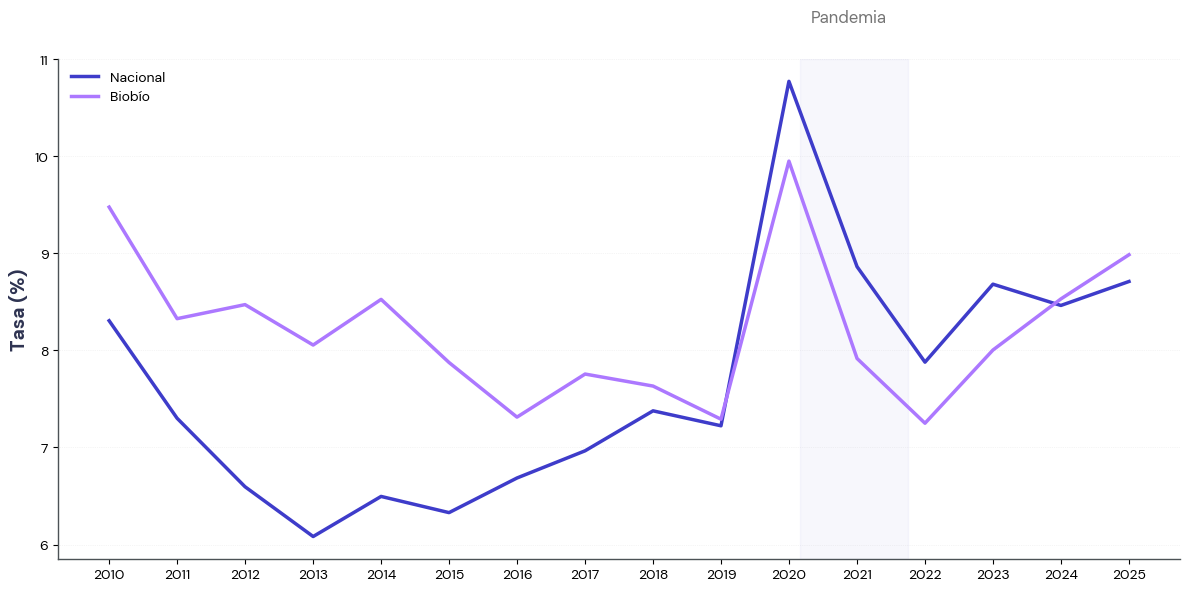

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path

# ─── Configurar fuente DM Sans ────────────────────────────────────────────────
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})



# ─── Paleta de colores ────────────────────────────────────────────────────────
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",  # azul institucional
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",  # otros tonos
]

# ─── Cargar datos ─────────────────────────────────────────────────────────────
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ─── Filtrar Nacional y Biobío ────────────────────────────────────────────────
df_nac = df[df["region_name"] == "Nacional"]
df_bio = df[df["region_name"] == "Biobío"]



# ─── Calcular promedio anual ──────────────────────────────────────────────────
df_nac_anual = df_nac.groupby("Año")["T_TDO_indicadoresprincipales"].mean().reset_index()
df_bio_anual = df_bio.groupby("Año")["T_TDO_indicadoresprincipales"].mean().reset_index()

# ─── Convertir año a fecha para usar eje temporal ─────────────────────────────
df_nac_anual["Fecha"] = pd.to_datetime(df_nac_anual["Año"].astype(str) + "-01-01")
df_bio_anual["Fecha"] = pd.to_datetime(df_bio_anual["Año"].astype(str) + "-01-01")

import matplotlib.dates as mdates
from matplotlib.dates import date2num

# ─── Crear gráfico ────────────────────────────────────────────────────────────
# ─── Crear gráfico con fechas como eje ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado leve para pandemia
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Líneas de promedio anual
ax.plot(df_nac_anual["Fecha"], df_nac_anual["T_TDO_indicadoresprincipales"],
        label="Nacional", color=PALETTE[3], linewidth=2.5)
ax.plot(df_bio_anual["Fecha"], df_bio_anual["T_TDO_indicadoresprincipales"],
        label="Biobío", color=PALETTE[6], linewidth=2.5)

# Texto “Pandemia”
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.03,
    "Pandemia",
    fontproperties=dm_font,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Ejes y formato
ax.set_ylabel("Tasa (%)", fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])

ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font)

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font)

plt.tight_layout()
plt.show()



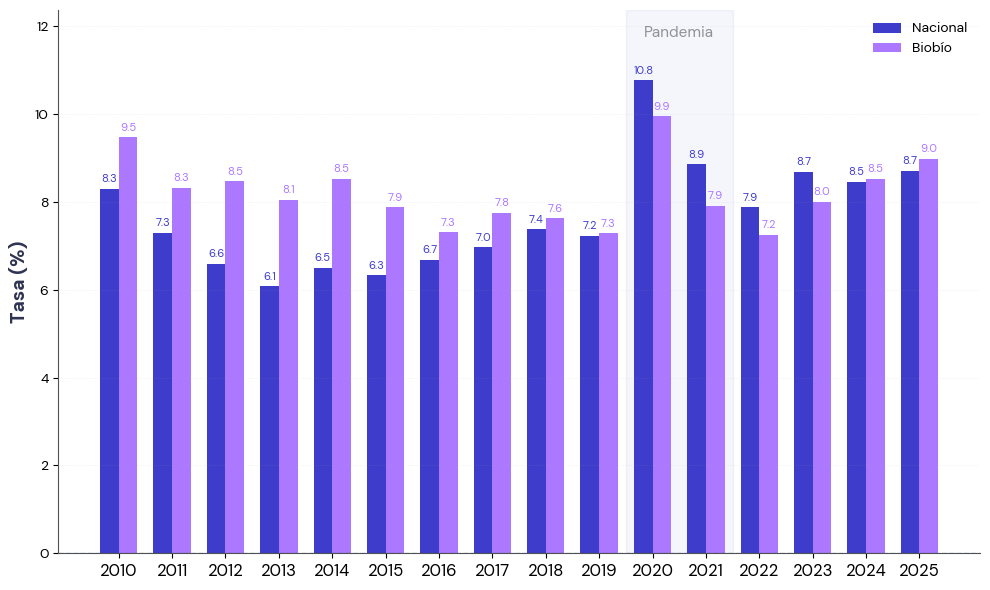

✅ Gráfico guardado: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# ─── 1. Configuración inicial ─────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# Paleta institucional
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# Paths
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png")

# ─── 2. Cargar fuentes DM Sans desde Drive ────────────────────────────────────
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── 3. Cargar datos y calcular promedio anual ────────────────────────────────
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df["Año"] = df["Fecha"].dt.year

prom = df.groupby(["Año", "region_name"])["T_TDO_indicadoresprincipales"].mean().unstack()
prom = prom[prom.index >= 2010]  # Puedes ajustar este filtro

# ─── 4. Gráfico de barras ─────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(prom.index))

# Barras
ax.bar(x - bar_width/2, prom["Nacional"], width=bar_width,
       color=PALETTE[3], label="Nacional")
ax.bar(x + bar_width/2, prom["Biobío"], width=bar_width,
       color=PALETTE[6], label="Biobío")

# Eje X
ax.set_xticks(x)
ax.set_xticklabels(prom.index, fontproperties=dm_font_props, fontsize=12)

# Eje Y
ax.set_ylabel("Tasa (%)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.tick_params(axis='y', labelsize=11)
for label in ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Línea cero y rejilla
ax.axhline(0, color=PALETTE[0], linestyle="--", linewidth=1, alpha=0.4)
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Sombreado pandemia
x_dict = {año: i for i, año in enumerate(prom.index)}
if 2020 in x_dict and 2021 in x_dict:
    ax.axvspan(x_dict[2020] - 0.5, x_dict[2021] + 0.5,
               color=PALETTE[3], alpha=0.05, zorder=0)
    x_centro = (x_dict[2020] + x_dict[2021]) / 2  # ← Definir aquí

# Layout antes de insertar texto para conocer los límites
plt.tight_layout()
plt.draw()

# 1. Subimos límite del eje Y con margen cómodo
y_max = prom.max().max() + 1.6
ax.set_ylim(0, y_max)

# 2. Texto “Pandemia” más arriba, sin superposición
ax.text(x_centro, y_max * 0.97,
        "Pandemia", ha="center", va="top",
        fontsize=11, fontproperties=dm_font_props,
        color=PALETTE[0], alpha=0.6)

# 3. Etiquetas sobre barras, más espaciadas
for i, año in enumerate(prom.index):
    nac_val = prom.loc[año, "Nacional"]
    bio_val = prom.loc[año, "Biobío"]

    ax.text(x[i] - bar_width/2, nac_val + 0.15, f"{nac_val:.1f}",
            ha="center", fontsize=8, fontproperties=dm_font_props,
            color=PALETTE[3])

    ax.text(x[i] + bar_width/2, bio_val + 0.15, f"{bio_val:.1f}",
            ha="center", fontsize=8, fontproperties=dm_font_props,
            color=PALETTE[6])

# Leyenda
ax.legend(frameon=False, loc="upper right",
          prop=dm_font_props, fontsize=12)

# Bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])

# Mostrar y guardar
plt.show()

try:
    OUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUT_FILE, dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    print(f"✅ Gráfico guardado: {OUT_FILE}")
except Exception as e:
    print(f"⚠️ Error al guardar: {e}")


# Mapas de calor


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


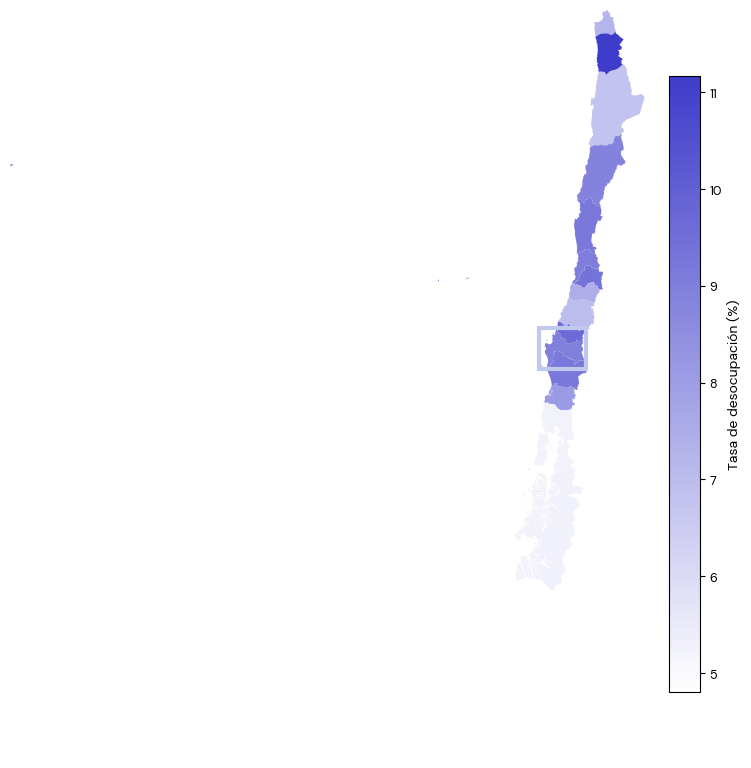

In [212]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import numpy as np
import matplotlib.font_manager as fm

# ─── 1. Cargar shapefile y datos ─────────────────────────────────────────────
shp_path = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/shp_regiones/Regional.shp")
xls_path = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")

gdf = gpd.read_file(shp_path)
df = pd.read_excel(xls_path, sheet_name='panel_data')
df = df[(df['Periodo'] == '2025Q1') & (~df['region_name'].isin(['Nacional']))]

# ─── 2. Limpieza de nombres ──────────────────────────────────────────────────
def quitar_comillas(s):
    if isinstance(s, str):
        return s.replace("'", "").replace("’", "").replace("‘", "").replace("`", "").strip()
    return s

df['region_name'] = df['region_name'].apply(quitar_comillas)
gdf['Region'] = gdf['Region'].apply(quitar_comillas)

mapeo = {
    'Antofagasta': 'Región de Antofagasta',
    'Araucanía': 'Región de La Araucanía',
    'Arica y Parinacota': 'Región de Arica y Parinacota',
    'Atacama': 'Región de Atacama',
    'Aysén': 'Región de Aysén del Gral.Ibañez del Campo',
    'Biobío': 'Región del Bío-Bío',
    'Coquimbo': 'Región de Coquimbo',
    'Los Lagos': 'Región de Los Lagos',
    'Los Ríos': 'Región de Los Ríos',
    'Magallanes': 'Región de Magallanes y Antártica Chilena',
    'Maule': 'Región del Maule',
    'OHiggins': 'Región del Libertador Bernardo OHiggins',
    'Región Metropolitana': 'Región Metropolitana de Santiago',
    'Tarapacá': 'Región de Tarapacá',
    'Valparaíso': 'Región de Valparaíso',
    'Ñuble': 'Región de Ñuble'
}
df['region_shp'] = df['region_name'].map(mapeo)

# ─── 3. Merge con datos y cálculo de tasas ───────────────────────────────────
df_grouped = df.groupby('region_shp')['T_TDO_indicadoresprincipales'].mean().reset_index(name='tasa_desocupacion')
gdf = gdf.merge(df_grouped, left_on='Region', right_on='region_shp', how='left')
gdf = gdf[gdf['Region'] != 'Zona sin demarcar']

# ─── 4. Paleta institucional azul ────────────────────────────────────────────
cmap = LinearSegmentedColormap.from_list("degrade_continuo", ["#ffffff", "#3e3cca"], N=256)

# ─── 5. Figura principal ─────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 20))
gdf.plot(
    column='tasa_desocupacion',
    cmap=cmap,
    linewidth=0,
    edgecolor='none',
    ax=ax,
    legend=False,
    vmin=gdf['tasa_desocupacion'].min(),
    vmax=gdf['tasa_desocupacion'].max(),
    missing_kwds={"color": "#e8e8e8"}
)

# Forzar a mostrar TODO el país
ax.set_xlim(gdf.total_bounds[0], gdf.total_bounds[2])
ax.set_ylim(gdf.total_bounds[1], gdf.total_bounds[3])
ax.set_axis_off()

# ─── 6. Cuadro sobre Biobío ──────────────────────────────────────────────────
try:
    row_bio = gdf[gdf['region_shp'] == 'Región del Bío-Bío'].iloc[0]
    bounds = row_bio.geometry.bounds
    x_center = (bounds[0] + bounds[2]) / 2
    y_center = (bounds[1] + bounds[3]) / 2
    width = (bounds[2] - bounds[0]) * 1.05
    height = (bounds[3] - bounds[1]) * 1.05
    ax.add_patch(Rectangle(
        (x_center - width/2, y_center - height/2),
        width, height,
        facecolor='none',
        edgecolor='#C0C8EB',
        linewidth=3,
        zorder=5
    ))
except:
    print("⚠ No se encontró Biobío para destacar")

# ─── 7. Barra de color integrada ─────────────────────────────────────────────
norm = mcolors.Normalize(vmin=gdf['tasa_desocupacion'].min(), vmax=gdf['tasa_desocupacion'].max())
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []

cbar = fig.colorbar(sm, ax=ax, shrink=0.4, pad=0.02)
cbar.set_label("Tasa de desocupación (%)", fontsize=10)
cbar.ax.tick_params(labelsize=9)

# ─── 8. Guardar como PNG limpio ──────────────────────────────────────────────
plt.savefig("mapa_desocupacion_chile_q1_2025.png", dpi=300, bbox_inches='tight')
plt.show()


Regiones en el shapefile:
['Región de Arica y Parinacota' 'Región de Tarapacá'
 'Región de Antofagasta' 'Región de Magallanes y Antártica Chilena'
 'Región de Aysén del Gral.Ibañez del Campo' 'Región de Atacama'
 'Región de Coquimbo' 'Región de Valparaíso'
 'Región Metropolitana de Santiago' 'Región de Los Lagos'
 'Región de Los Ríos' 'Región de La Araucanía' 'Región del Bío-Bío'
 'Región de Ñuble' 'Región del Maule'
 'Región del Libertador Bernardo OHiggins' 'Zona sin demarcar']

Total regiones en shapefile: 17

Regiones en los datos:
['Aysén' 'Antofagasta' 'Arica y Parinacota' 'Araucanía' 'Atacama' 'Biobío'
 'Coquimbo' 'OHiggins' 'Los Lagos' 'Los Ríos' 'Magallanes' 'Maule' 'Ñuble'
 'Región Metropolitana' 'Tarapacá' 'Valparaíso']

Total regiones en datos: 16

Después de la limpieza:
Nombres únicos en los datos:
['Aysén' 'Antofagasta' 'Arica y Parinacota' 'Araucanía' 'Atacama' 'Biobío'
 'Coquimbo' 'OHiggins' 'Los Lagos' 'Los Ríos' 'Magallanes' 'Maule' 'Ñuble'
 'Región Metropolitana' 'T

<ipython-input-214-2833140362>:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


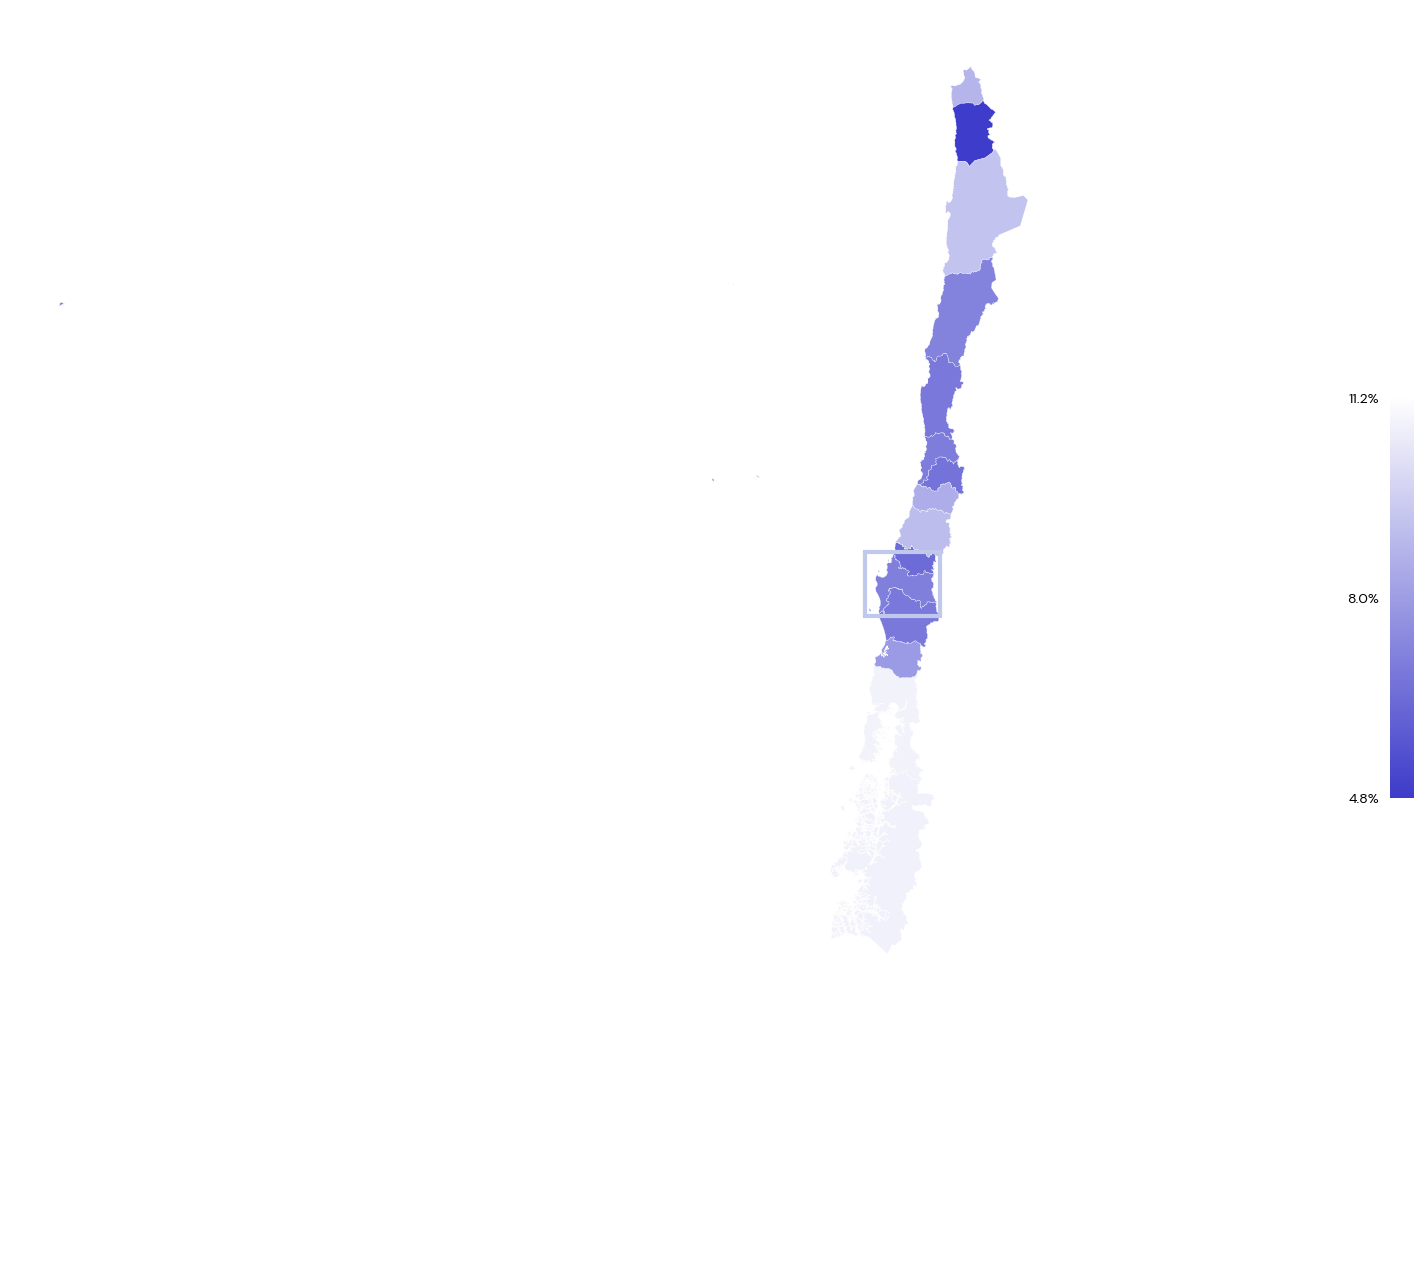


Rango de valores: 4.81% - 11.17%
Número de regiones con datos: 16
Número total de regiones: 16


In [214]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from pathlib import Path
import matplotlib.font_manager as fm
import numpy as np

# ─── 1. Rutas y carga ────────────────────────────────────────────────────────
shp_path = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/shp_regiones/Regional.shp")
xls_path = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")

gdf = gpd.read_file(shp_path)
df = pd.read_excel(xls_path, sheet_name='panel_data')
df = df[(df['Periodo'] == '2025Q1') & (~df['region_name'].isin(['Nacional']))]

# ─── 2. Eliminar comillas para asegurar match de nombres ─────────────────────
def quitar_comillas(s):
    if isinstance(s, str):
        return s.replace("'", "").replace("’", "").replace("‘", "").replace("`", "").strip()
    return s

df['region_name'] = df['region_name'].apply(quitar_comillas)
gdf['Region'] = gdf['Region'].apply(quitar_comillas)


# ─── 3. Verificar nombres únicos y crear mapeo ──────────────────────────────
print("Regiones en el shapefile:")
print(gdf['Region'].unique())
print(f"\nTotal regiones en shapefile: {len(gdf['Region'].unique())}")

print("\nRegiones en los datos:")
print(df['region_name'].unique())
print(f"\nTotal regiones en datos: {len(df['region_name'].unique())}")

# Diccionario de mapeo actualizado
mapeo = {
    'Antofagasta': 'Región de Antofagasta',
    'Araucanía': 'Región de La Araucanía',
    'Arica y Parinacota': 'Región de Arica y Parinacota',
    'Atacama': 'Región de Atacama',
    'Aysén': 'Región de Aysén del Gral.Ibañez del Campo',
    'Biobío': 'Región del Bío-Bío',
    'Coquimbo': 'Región de Coquimbo',
    'Los Lagos': 'Región de Los Lagos',
    'Los Ríos': 'Región de Los Ríos',
    'Magallanes': 'Región de Magallanes y Antártica Chilena',
    'Maule': 'Región del Maule',
    'OHiggins': 'Región del Libertador Bernardo OHiggins',
    'Región Metropolitana': 'Región Metropolitana de Santiago',
    'Tarapacá': 'Región de Tarapacá',
    'Valparaíso': 'Región de Valparaíso',
    'Ñuble': 'Región de Ñuble'
}

df['region_shp'] = df['region_name'].map(mapeo)

# Verificar el mapeo después de la limpieza
print("\nDespués de la limpieza:")
print("Nombres únicos en los datos:")
print(df['region_name'].unique())

# Verificar el mapeo
print("\nVerificación del mapeo:")
print("Regiones no mapeadas en los datos:")
no_mapeadas = df[df['region_shp'].isna()]['region_name'].unique()
print(no_mapeadas)

print("\nRegiones del shapefile sin datos:")
df_grouped = df.groupby('region_shp')['T_TDO_indicadoresprincipales'].mean().reset_index(name='tasa_desocupacion')
regiones_con_datos = set(df_grouped['region_shp'].unique())
regiones_shp = set(gdf['Region'].unique())
sin_datos = regiones_shp - regiones_con_datos
print(sin_datos)

gdf = gdf.merge(df_grouped, left_on='Region', right_on='region_shp', how='left')

# Eliminar "Zona sin demarcar" del GeoDataFrame
gdf = gdf[gdf['Region'] != 'Zona sin demarcar']

print(f"\nZona sin demarcar eliminada del mapa")

# Mostrar regiones con valores faltantes
print(f"\nRegiones con datos faltantes en el mapa final:")
regiones_na = gdf[gdf['tasa_desocupacion'].isna()]['Region'].tolist()
print(regiones_na)

# ─── 4. Cargar fuente DM Sans (opcional) ─────────────────────────────────────
try:
    font_path = "/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf"
    fm.fontManager.addfont(font_path)
    dm_font = fm.FontProperties(fname=font_path)
except:
    dm_font = None

# ─── 5. Paleta continua: blanco a azul institucional ─────────────────────────
cmap = LinearSegmentedColormap.from_list("degrade_continuo", [
    "#ffffff",  # claro para valores bajos
    "#3e3cca"   # azul institucional para valores altos
], N=256)

# ─── 6. Crear figura simple ──────────────────────────────────────────────────
fig, ax_map = plt.subplots(figsize=(12, 16))

# Crear el mapa
im = gdf.plot(
    column='tasa_desocupacion',
    cmap=cmap,
    linewidth=0.2,
    edgecolor='white',
    ax=ax_map,
    legend=False,
    vmin=gdf['tasa_desocupacion'].min(),
    vmax=gdf['tasa_desocupacion'].max(),
    missing_kwds={"color": "#e8e8e8", "edgecolor": "white", "linewidth": 0.8}
)

# ─── 7. Añadir rectángulo sobre el Biobío ───────────────────────────────────
try:
    row_bio = gdf[gdf['region_shp'] == 'Región del Bío-Bío'].iloc[0]
    bounds = row_bio.geometry.bounds
    x_center = (bounds[0] + bounds[2]) / 2
    y_center = (bounds[1] + bounds[3]) / 2
    width = (bounds[2] - bounds[0]) * 1.1
    height = (bounds[3] - bounds[1]) * 1.1

    ax_map.add_patch(Rectangle(
        (x_center - width/2, y_center - height/2), width, height,
        facecolor='none',
        edgecolor='#C0C8EB',
        linewidth=3,
        zorder=5
    ))
except:
    print("No se pudo encontrar la región del Biobío")

# ─── 8. Crear barra minimalista y compacta ──────────────────────────────────
# Calcular rangos
min_val = gdf['tasa_desocupacion'].min()
max_val = gdf['tasa_desocupacion'].max()

# Posición de la barra - más pequeña y centrada
bar_x = 1.2     # posición horizontal
bar_y = 0.4       # centrada verticalmente
bar_width = 0.02  # más delgada
bar_height = 0.25 # solo 25% del alto total (minimalista)

# Crear la barra gradiente compacta
bar_ax = fig.add_axes([bar_x, bar_y, bar_width, bar_height])
gradient = np.linspace(0, 1, 256).reshape(256, -1)
bar_ax.imshow(gradient, aspect='auto', cmap=cmap, extent=[0, 1, min_val, max_val])

# Configurar la barra
bar_ax.set_xlim(0, 1)
bar_ax.set_ylim(min_val, max_val)
bar_ax.set_xticks([])

# Solo 3 etiquetas (mínimo, medio, máximo) - súper minimalista
tick_values = [min_val, (min_val + max_val) / 2, max_val]
tick_labels = [f'{val:.1f}%' for val in tick_values]

bar_ax.set_yticks(tick_values)
bar_ax.set_yticklabels(tick_labels, fontsize=9,
                       fontproperties=dm_font if dm_font else None)
bar_ax.tick_params(axis='y', length=0, pad=8)

# Quitar todos los bordes
for spine in bar_ax.spines.values():
    spine.set_visible(False)

# ─── 9. Configurar mapa principal ────────────────────────────────────────────
ax_map.set_axis_off()

# Ajustar layout
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

plt.show()

# ─── 10. Información adicional para debugging ───────────────────────────────
print(f"\nRango de valores: {min_val:.2f}% - {max_val:.2f}%")
print(f"Número de regiones con datos: {gdf['tasa_desocupacion'].notna().sum()}")
print(f"Número total de regiones: {len(gdf)}")